# Home Assignment 2 - Quality Assessment
**Author:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 <br>

## 0.0. Prerequisites

In the code I use NumPy, Matplotlib, Hugging Face datasets & transformers, faiss, and PyTorch packages. Please, install them in your environment by running the following cells. Also, I've left exactly the same cells before the actual usage of these packages.

In [ ]:
%pip install numpy

In [ ]:
%pip install matplotlib

In [ ]:
%pip install datasets transformers[sentencepiece]

In [ ]:
%pip install faiss-cpu

In [ ]:
%pip install pytorch torchvision torchaudio cpuonly -c pytorch

# 1. Measure and improve

How do we know that search engine's quality improved (or at least haven't deteriorated) because of our changes?

All we need is a way to ***evaluate*** our search engine. We will consider some of the popular evaluation techniques:

1. Mean Average Precision
2. 11-Point Interpolated Average
3. Normalized Discounted Cumulative Gain (NDCG)
4. pFound

<!--We will apply them in the context of ranking with language models and will compare two ways of smoothing: additive and Jelinek-Mercer smoothing.
-->

It's best to go through the [book](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf) *chapter 8*, concretely, *8.4* to understand the key concepts of this lab. Here we will only present some excerpts from it.

## 1.1. [10] Mean Average Precision

The most standard metric among the TREC community is *Mean Average Precision* *(MAP)*, which provides a single-figure measure of quality across recall levels. Among evaluation measures, MAP has been shown to have especially good discrimination and stability. For a single information need, Average Precision is the average of the precision value obtained for the set of top $k$ documents existing
after each relevant document is retrieved, and this value is then averaged over information needs (queries). 
Assume we have a bucket $Q$ of queries $q_j\in Q$.
If the set of **relevant documents** for an information need (query) $q_j$ is {d<sub>1</sub>, . . . d<sub>m<sub>j</sub></sub>} and R<sub>jk</sub> is the set of ranked retrieval results from the top result until you get to document d<sub>k</sub>, then

![](https://i.imgur.com/EGQMHVq.png)

Implement this metric in the `mean_avg_precision` function.

**NB** Don't make the name of [the metric confuse you](https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52). *Average Precision* is the term, which corresponds to the area under precision-recall curve. It's computation is tricky. We suggest to start with implementing [$AveP$](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision).

In [ ]:
%pip install numpy

In [1]:
import numpy as np

In [2]:
def generate_mask(search_result, relevance):
    """
    Method that generates binary mask of relevant documents for a given
    set of ranked retrieval results. 

    :param search_result: set of ranked retrieval results.
    :param relevance: set of relevant documents.
    :return: binary mask.
    """
    relevant_idxs = [idx for idx, _ in relevance]
    mask = np.array([0 for _ in range(len(search_result))])
    for idx, result in enumerate(search_result):
        if result in relevant_idxs:
            mask[idx] = 1
    return mask


def compute_precisions(mask):
    """
    Method that computes precisions for each entry in a given binary mask.
    Precision treated as a fraction of retrieved documents that are relevant, i.e.
    #relevant items retrieved / #retrieved items (see An Introduction to Information
    Retrieval, 8.3). 

    :param mask: binary mask of relevant documents.
    :return: array of precisions and number of relevant documents retrieved.
    """
    precisions = np.array([0 for _ in range(len(mask))], dtype=np.float64)
    hits = 0
    for idx, relevance in enumerate(mask):
        if relevance == 1:
            hits += 1
        precisions[idx] = hits / (idx + 1)
    return precisions, hits


def mean_avg_precision(search_results, relevance):
    """
    Method that computes Mean Average Precision for set of queries. Treats relevance scores 
    as binary (suggested in specification). For each query iteratively generates binary mask 
    of relevant documents. Based on the binary mask computes precisions for each document in 
    a set of retrieved results. Computes average precision as a fraction of sum of precisions 
    for relevant documents and numver of relevant documents retrieved. Takes the mean over
    average precisions for all queries.
    
    :search_results: set of ranked retrieval results.
    :relevance: set of relevant documents.
    :return: mean average precision over all queries.
    """
    
    queries_num = len(search_results)
    average_precisions = np.array([0 for _ in range(queries_num)], dtype=np.float64)
    for idx, search_result in enumerate(search_results):
        relevant_docs = relevance[idx + 1]
        binary_mask = generate_mask(search_result, relevant_docs)
        precisions, hits = compute_precisions(binary_mask)
        average_precision = 0
        if hits:
            average_precision = np.sum(precisions * binary_mask) / hits
        average_precisions[idx] = average_precision
    mean_average_precision = np.mean(average_precisions)
    return mean_average_precision

### 1.1.1. Tests

In [3]:
import numpy as np

test_relevance = {1: [(9, 1), (1, 2), (8, 3)], 2: [(5, 1), (9, 2), (6, 3)], 
                  3: [(9, 1), (4, 2), (6, 3)], 4: [(10, 1), (4, 2), (7, 3)], 
                  5: [(4, 1), (2, 2), (8, 3)], 6: [(2, 1), (9, 2), (4, 3)], 
                  7: [(1, 1), (2, 2), (3, 3)], 8: [(3, 1), (2, 2), (6, 3)], 
                  9: [(1, 1), (4, 2), (3, 3)], 10: [(10, 1), (7, 2), (8, 3)]}
test_results = [[4, 5, 3, 6, 1, 2, 8, 9, 10, 7], [7, 5, 6, 3, 1, 8, 9, 4, 2, 10], 
                [8, 3, 4, 5, 9, 6, 1, 10, 2, 7], [4, 5, 7, 3, 6, 10, 1, 9, 2, 8], 
                [4, 8, 3, 5, 6, 7, 2, 1, 10, 9], [9, 7, 6, 5, 2, 4, 10, 1, 3, 8], 
                [3, 1, 5, 2, 10, 6, 7, 9, 8, 4], [9, 2, 4, 10, 8, 3, 7, 6, 1, 5], 
                [3, 4, 6, 1, 5, 10, 7, 2, 8, 9], [8, 10, 4, 1, 3, 7, 5, 6, 9, 2]]


map_test = mean_avg_precision(test_results, test_relevance)
print("map_test", map_test)
assert np.isclose(map_test, 0.646, atol=1e-03)
assert mean_avg_precision(test_results[:5], test_relevance) > mean_avg_precision(test_results[5:10], test_relevance)

map_test 0.6464285714285714


## 1.2. [15] 11-Point Interpolated Average

In a ranked retrieval context, appropriate sets of retrieved documents are naturally given by the top k retrieved documents. For each such set, precision and recall values can be plotted to give a precision-recall curve, such as this one (blue line):

![](https://i.imgur.com/QnvDLAJ.png)

Precision-recall curves have a distinctive saw-tooth shape: if the *(k + 1)<sup>th</sup>* document retrieved is nonrelevant then recall is the same as for the top k documents, but precision has dropped. If it is relevant, then both precision and recall increase, and the curve jags up and to the right.

It is often useful to remove these jiggles and the standard way to do this is with an *interpolated precision*: the interpolated precision *p<sub>interp</sub>* at a certain recall level *r* is defined as the highest precision found for any recall level *r′* ≥ *r*:

![](https://i.imgur.com/GMl2rQw.png)

The justification is that almost anyone would be prepared to look at a few more documents if it would increase the percentage of the viewed set that were relevant (that is, if the precision of the larger set is higher). Interpolated precision is shown by a red line in the figure above.

Examining this information for a single query may be useful, but usually we are more interested in a composite metrics, which will score over all test queries. The traditional way of doing this is the *11-point interpolated average*. For each information need, the interpolated precision is measured at the 11 recall levels of 0.0, 0.1, 0.2, . . . , 1.0. Then we average interpolated precision over all queries in the test collection and plot, like here:

![](https://i.imgur.com/6wDmtp2.png)


Plotting a number of such graphs for different versions of search engine on the same plot helps to compare their performance.

You need to incorporate this logic into `eleven_points_interpolated_avg` function. Break it down to subfuctions as it seems necessary to you.

In [ ]:
%pip install matplotlib

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [5]:
def generate_mask(search_result, relevance):
    """
    Method that generates binary mask of relevant documents for a given
    set of ranked retrieval results. 

    :param search_result: set of ranked retrieval results.
    :param relevance: set of relevant documents.
    :return: binary mask.
    """
    relevant_idxs = [idx for idx, _ in relevance]
    mask = np.array([0 for _ in range(len(search_result))])
    for idx, result in enumerate(search_result):
        if result in relevant_idxs:
            mask[idx] = 1
    return mask


def compute_precisions(mask):
    """
    Method that computes precisions for each entry in a given binary mask.
    Precision treated as a fraction of retrieved documents that are relevant, i.e.
    #relevant items retrieved / #retrieved items (see An Introduction to Information
    Retrieval, 8.3). 

    :param mask: binary mask of relevant documents.
    :return: array of precisions and number of relevant documents retrieved.
    """
    precisions = np.array([0 for _ in range(len(mask))], dtype=np.float64)
    hits = 0
    for idx, relevance in enumerate(mask):
        if relevance == 1:
            hits += 1
        precisions[idx] = hits / (idx + 1)
    return precisions, hits


def compute_recalls(mask):
    """
    Method that computes recalls for each entry in a given binary mask.
    Recall treated as a fraction of relevant documents that are retrieved, i.e.
    #relevant items retrieved / #relevant items (see An Introduction to Information
    Retrieval, 8.3). 

    :param mask: binary mask of relevant documents.
    :return: array of recalls.
    """    
    recalls = np.array([0 for _ in range(len(mask))], dtype=np.float64)
    relevant_docs_num = np.count_nonzero(mask)
    hits = 0
    for idx, relevance in enumerate(mask):
        if relevance == 1:
            hits += 1
        recalls[idx] = 0
        if relevant_docs_num:
            recalls[idx] = hits / relevant_docs_num
    return recalls


def interpolate(precisions, recalls):
    """
    Method that generates a list of tuples (r, p), where r is a certain recall level and
    p is an interpolated precision at r. The interpolated precision at r is defined as a 
    highest precision found for any recall level r' >= r (see An Introduction to Information
    Retrieval, 8.4). For each of 11 recall levels iteratively searches for maximal precision 
    (desired interpolation) belonging to greater or equal recall level.

    :param recall: set of recalls for each document in retrieval results.
    :param precision: set of precisions for each document in retrieval results.
    :return: list of tuples (r, p), where r stands for recall level and p - for interpolated precision.
    """
    interpolation = []
    for i in range(11):
        threshold = i / 10
        max_precision = -1
        for recall, precision in zip(recalls, precisions):
            if recall >= threshold and precision > max_precision:
                max_precision = precision
        interpolation.append((threshold, max_precision))
    return interpolation


def average_interpolation(interpolations):
    """
    Method that computes interpolated average over all queries. For each recall 
    level iteratively computes the average precision. 

    :param interpolations: list of lists of tuples tuples (r, p), where r stands for recall level and p - for interpolated precision.
    :return: arrays with average interpolated precisions and recall levels.
    """
    if len(interpolations) == 0:
        return [], []
    precisions, recalls = [], []
    docs_num = len(interpolations[0])
    for idx in range(docs_num):
        pairs = [interpolation[idx] for interpolation in interpolations]
        if len(pairs) == 0:
            continue
        _recall = pairs[0][0]
        _precisions = np.array([pair[1] for pair in pairs])
        average_precision = np.mean(_precisions) 
        recalls.append(_recall)
        precisions.append(average_precision)
    precisions, recalls = np.array(recalls), np.array(precisions)
    return precisions, recalls


def plot_curve(recall, precision):
    """
    Method that plot the 11-point interpolated average. Interpolated
    precision is measured at 11 recall levels.

    :param recall: set of recalls for each document in retrieval results.
    :param precision: set of precisions for each document in retrieval results.
    """
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(12, 12)
    ax1.set_title("Averaged 11-point precision/recall graph")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xticks(recall)
    ax1.set_yticks(recall)
    ax1.plot(recall, precision, '-o', c='r')
    plt.show()


def eleven_points_interpolated_avg(search_results, relevance, plot=True):
    """
    Method that computes 11-points interpolated average over all queries. For each query iteratively 
    computes set of precisions and correspondent set of recalls. Based on these two sets it makes 
    an 11-points interpolation. Once it is done for each query, interpolated precisions are averaged for 
    each of 11 recall levels. The precision/recall curve is plotted on demand.

    :search_results: set of ranked retrieval results.
    :relevance: set of relevant documents.
    :plot: flag signalizing whether the precision/recall curve should be plotted.
    :return: array of interpolated precisions.
    """
    interpolated = []
    for idx, search_result in enumerate(search_results):
        relevant_docs = relevance[idx + 1]
        mask = generate_mask(search_result, relevant_docs)
        precisions, _ = compute_precisions(mask)
        recalls = compute_recalls(mask)
        interpolation = interpolate(precisions, recalls)
        interpolated.append(interpolation)
    recalls, precisions = average_interpolation(interpolated)
    if plot:
        plot_curve(recalls, precisions)    
    return precisions

### 1.2.1.Tests

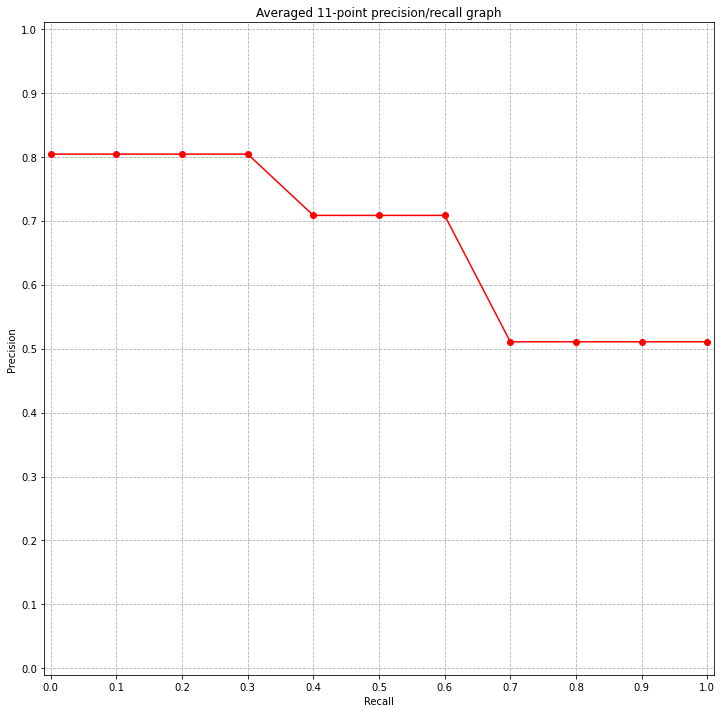

In [6]:
eleven_test = eleven_points_interpolated_avg(test_results, test_relevance, plot=True)
assert all(eleven_test[k] >= eleven_test[k+1] for k in range(len(eleven_test)-1))

## 1.3. [10] Normalized Discounted Cumulative Gain

NDCG metric is designed for situations of non-binary notions of relevance. It is evaluated over some number $k$ of top search results (in our case we will evaluate over the whole dataset, since it is small). 

For a set of queries $Q$, let $R(j,d)$ be the relevance score assessors gave to document $d$ for query $j$. Then,

![](https://i.imgur.com/LLogCYa.png)

where $Z_{kj}$ is a normalization factor calculated to make it so that a perfect ranking’s NDCG at $k$ for query $j$ is 1. In other words, we divide calculated DCG score by ideal DCG score. 

Implement this metric in `NDCG` function.

In [7]:
import math 

In [8]:
def DCG(search_result, relevance):
    """
    Method that computes Discounted Cumulative Gain for a given query.
    For each document iteratively computes the graded relevance with 
    logarithmic reduction factor in a given and ideal queries. In an ideal
    query top results are occupied by the relevant documents, from most to 
    least. Adding up the terms, obtain DCG for a given and ideal query. 
    The inverse of an ideal DCG is used a normalization factor Z.

    :search_results: set of ranked retrieval results.
    :relevance: set of relevant documents.
    :return: DCG for a given query and normalization factor Z.
    """
    dcg, rel_idx, ideal_dcg = 0, 0, 0
    dcg_formula = lambda r, m: (2 ** r - 1) / math.log2(m + 1) if math.log2(m + 1) != 0 else 0
    sorted_relevance = sorted(relevance.values(), reverse=True)
    for m, result in enumerate(search_result):
        doc_relevance = relevance[result] if result in relevance else 0
        ideal_doc_relevance = sorted_relevance[rel_idx] if rel_idx < len(sorted_relevance) else 0
        dcg += dcg_formula(doc_relevance, m + 1)
        ideal_dcg += dcg_formula(ideal_doc_relevance, m + 1)
        rel_idx += 1
    return dcg, 1 / ideal_dcg


def NDCG(search_results, relevance):   
    """
    Methods that computes Normalized Discounted Cumulative Gain (NDCG) for a given set of queries.
    For each retrieval result iteratively computes inverse scores for a relevant documents.
    Further, if calculates DCG and normalization factor for a query. The NDCG is computed 
    as a mean of DCGs for each query element-wise multiplied by Z normalization coefficients.

    :search_results: set of ranked retrieval results.
    :relevance: set of relevant documents.
    :return: NDCG for a given set of queries.
    """
    DCGs = np.array([0 for _ in range(len(search_results))], dtype=np.float64)
    Zs = np.array([0 for _ in range(len(search_results))], dtype=np.float64)
    invert_relevance = lambda relevance: {k: 5 - v for k, v in relevance}
    for idx, search_result in enumerate(search_results):
        relevant_docs = invert_relevance(relevance[idx + 1])
        DCGs[idx], Zs[idx] = DCG(search_result, relevant_docs)
    ndcg = np.mean(DCGs * Zs)
    return ndcg

### 1.3.1. Tests

In [9]:
ndcg_test = NDCG(test_results, test_relevance)
print("ndcg_test", ndcg_test)
assert np.isclose(ndcg_test, 0.640, atol=1e-03)
assert NDCG(test_results[:5], test_relevance) < NDCG(test_results[5:10], test_relevance)

ndcg_test 0.6409675295633275


## 1.4. [15] pFound ## 
**pFound** -- ranking metric invented in [Yandex](http://romip.ru/romip2009/15_yandex.pdf). This metric models user behaviour when looking at the search engine representation page (SERP). Metric assumes a user is inspecting a list from the top to the bottom. There are 2 global parameters, controlling behaviour:
- `pBreak` -- how probable, that the user will become tired and just quit at this position (`0.15` by default).
- `pRel` -- how probable the user will click the document if this document is relevant (`0.4` by default for a relevan document, `0` is given to irrelevant).

Then, to compute pFound for the exact page we do:

$pLook_i = pLook_{i-1}*(1 - pBreak)*(1 - pRel_{i-1})$

$pFound = \sum_{i=1}^{N}pLook_i*pRel_i$

Implement `pFound` below.

In [10]:
import math 

In [11]:
def generate_mask(search_result, relevance):
    """
    Method that generates binary mask of relevant documents for a given
    set of ranked retrieval results. 

    :param search_result: set of ranked retrieval results.
    :param relevance: set of relevant documents.
    :return: binary mask.
    """
    relevant_idxs = [idx for idx, _ in relevance]
    mask = np.array([0 for _ in range(len(search_result))])
    for idx, result in enumerate(search_result):
        if result in relevant_idxs:
            mask[idx] = 1
    return mask

def pFound(search_results, relevance):
    """
    Method that calculates pFound score for search results. Treats relevance scores 
    as binary (suggested in specification). Values of pBreak and pRel are takes 
    as 0.15 and 0.4 respectivelly. For each query iteratively computes pLook, pRel, and pFound
    according to recursive formulas given in original paper http://romip.ru/romip2009/15_yandex.pdf.
    The result is an average value of pFound.

    :search_results: set of ranked retrieval results.
    :relevance: set of relevant documents.
    :return: average pFound over all queries.
    """
    pBreakConst = 0.15
    pRelConst = 0.4
    pFounds = np.array([0 for _ in range(len(search_results))], dtype=np.float64)
    for i, search_result in enumerate(search_results):
        mask = generate_mask(search_result, relevance[i + 1])
        pLook = np.array([0 for _ in range(len(mask))], dtype=np.float64)
        pRel = np.array(mask) * pRelConst
        for idx in range(len(mask)):
            if idx == 0:
                pLook[idx] = 1
                continue
            pLook[idx] = pLook[idx - 1] * (1 - pRel[idx - 1]) * (1 - pBreakConst)
        pFounds[i] = np.sum(pLook * pRel)
    average_pFound = np.mean(pFounds)
    return average_pFound

### 1.4.1. Tests

In [12]:
pFound_test = pFound(test_results, test_relevance)
print("pFound", pFound_test)
assert np.isclose(pFound_test, 0.582, atol=1e-03)
assert pFound(test_results[:5], test_relevance) > pFound(test_results[5:10], test_relevance)

pFound 0.5821558180674999


# 2. [M] Evaluation of real search

Now we want to apply these metrics to some simple but real search engine. Print out all metrics you've just implemented for your search engine.

Please note that the data is the same, and metrics evaluate same search engine, so their results should not vary much.

## 2.0. Data

There is a number of ways to evaluate a search engine, however, all of them require so called relevance judgements - human assigned scores of relevance between `(query, doc_id)` pairs. We will use Cranfield relevance judgements collection, download it from [GDrive](https://drive.google.com/drive/folders/1u6dSUqdrXsckSHmVHNNE27eDiajMWLl2?usp=sharing) or [GitHub](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/cranfield_data). 

This was the pioneering test collection in allowing precise quantitative measures of information retrieval effectiveness, but is nowadays too small for anything but the most elementary pilot experiments (which is exactly what we are doing here). Collected in the United Kingdom starting in the late 1950s, it contains 1400 abstracts of aerodynamics journal articles, a set of 225 queries, and exhaustive relevance judgments of all (query, document) pairs.

![image.png](data:image/png;base64,%20iVBORw0KGgoAAAANSUhEUgAAA70AAAFXCAYAAABunSlhAAAgAElEQVR4Aey9z2vsTnb/rf2Y+Vtmq1W8zB/ysRbx7ru7s/H1YhYJTxpseLx4DLMMDnj3uWkMAYMhYb5JhnhlLmkz5BcY7MAsMoFJGMJ5OPVDOjqqkqolVbe6/b7g22pV1TmnXlXq0ltVkgrCPxAAARAAARAAARAAARAAARAAARA4UgLFkdYL1QIBEAABEAABEAABEAABEAABEAABqkXvH/3xrwl/YIA+gD6APoA+sOQ+kHvcXnLdERuOTfQB9AH0AfQB9IH0PiDPGVqiVyZgGwRAAARAAASWRIAH+tz/duEjdx1gHwRAAARAAAQ+OwE9nkP0fvYegfqDAAiAwIEQ0ANYjrB34SNH3LAJAiAAAiAAAiDQENDjOURvwwZbIAACIAACCyagB7Acoe7CR464YRMEQAAEQAAEQKAhoMdziN6GDbZAAARAAAQWTEAPYDlC3YWPHHHDJgiAAAiAAAiAQENAj+cQvQ0bbIEACIAACCyYgB7AcoS6Cx854oZNEAABEAABEACBhoAezyF6GzbYAgEQAAEQWDABPYDlCDXZx2ZNVVlQUa1zhAGbIAACIAACIAACEwjo8RyidwJMFAUBEAABENgdAT2A5fCc6mOzKqlcbXKEAJsgAAIgAAIgAAITCejxvF/04kr2RNwoDgIgAAIgMBcBPYDNZVfaSfUB0SupYRsEQAAEQAAElkVAj+e9oheD+rIaD9GAAAiAwGcmoAewHCxSfWB8zEEfNkEABEAABEBgHgJ6PIfonYcrrIAACIAACGQmoAewHO5SfUD05qAPm5+GwL+/0Q9//Gvi483//eJX+Wv/N3/2a/qjP3mjf83vCh5AAAT2TECP5xC9e24QuAcBEAABEEgjoAewtFLb5UrysV5RWZS0xi2928FFbhBgAr/6Df3RH7/QX/y7wOFE8C6Er/CKTRAAgSMmoMdziN4jbuymar+nv/iT5moqdwL+O9bB5V//8oX+6M9+21QfWyAAAkdBQA9gOSqV6gMzvTnow+bxE/gt/SJy/mHG7noW1p63tM5TWCzX6UxKn9v8hv6mBsh+Xugv/pIFNp/z2DQz09s6P+izQWRiqmejlVCvfWEDBEBgiQT0eB4XvbiSvcT2GxmT/VH/4S9/35Q3V1p/Ta19TepBb0H0HnTzIXgQiBLQA1g044SEVB8QvRMgo+jnJWBmdCPisZU2LHq1gG2LZiuuvdj1wHUZ/b1lw8QjhbS3gk8QAIFDIKDH87joJSIM6ofQpCkxBkQvFzPCV/6g91/xJLf8iDsR/9krsEMDE6fzAOcHIH/FVfrSA6BM8/l9Pb0/ac+X1+UaUY+rtZ4fPkHgcAnoASxHTVJ9YHzMQR82j55A57xD1Hgb0dvK62242V2zbNqeI7RmiomoJXKHbLhzHm3De8MnCIDAsgno8Ryid9ntNVN0Vgx2Z3XloOAEo1j2Y4WiF8U2b2Pjt/QLs8zIi1ARamsJkhei3o7/7kWzWz4kliy1BiXS6b68F7pqEPP5RT2sWPf+RZzYBAEQOCgCegDLEXyqDyN6q3WOEGATBI6XQFBouuq20gbOLZwg5eO1/efPDeT5TYOzdX4xaINIXuxvzn8ae9gCARBYLgE9nkP0LretZozMDh7dH2wxKJgffy0MOd0NINGrswMDk7vnRl4pNWJailJpuzXoeQQijoA9M2MtRHPHvhvYZAzeMj5BAAQOh4AewHJEnuwD77HPgR82j56AOO9QdTVjdz2WD5xbBM9ZpMGwn67o1ec90obcDtuTObANAiCwLAJ6PB8WvbiSvawWHBVNguiVwrP2IQad1uxtnaF+kERLULbyChuuWEeUSt9OoHJHbf/5q7dde4Oil/0Ku13xL+uDbRAAgaUS0ANYjjh34SNH3LAJAodCwJwD+AvqPmhzHtCsAOPdXYEqXzcUO6/xBsMitWXTXURPOycInHt4V/gEARBYJAE9nveKXsKV7EU24vZBRQaHjtjUVzx50NjHTK+OQ9Y4MPC0RLZbDi1nkmVxCg+ErSz4AgIgsEgCegDLEeQufOSIGzZB4JAIWOGrL27rZ3jY8ZqPSfNAKjXWd5/eLEVxeKxvi14mZs8prA8Xj59tdkK8ToueVxwSecQKAp+HgB7P+0Xv5+Fy5DUNiF4389lc4XQ//OJHvb3UyA4gTX5/T2/a1Vg5E9w70zt45TVR9PpBq9OygfKdPNgBAiCwRAJ6AMsR4y585IgbNkHgKAg4oSnPGY6iXqgECIDAzgno8Ryid+dNsA+HTtC2lgz75cIyHnlVVV4xdXnEEuH2i+Vlud/Q37SuxnZFZr/oZV+BeGsR27Wnlzd3ljLjaq1sZGyDwMES0ANYjoqk+Hh7e8vhGjZBAARAAARAAARmIqDHc4jemcDCDAiAAAiAQF4CegDL4S3FB0RvDvKwCQIgAAIgAALzEdDjeVT0YlCfDzosgQAIgAAITCegB7DpFrsWUnxgfOxywx4QAAEQAAEQWBIBPZ5D9C6pdRALCIAACIBAlIAewKIZJySk+IDonQAYRUEABEAABEBgBwT0eA7RuwPocAECIAACIDCdgB7AplvsWkjxAdHb5YY9IAACIAACILAkAno8h+hdUusgFhAAARAAgSgBPYBFM05ISPEB0TsBMIqCAAiAAAiAwA4I6PEconcH0OECBEAABEBgOgE9gE232LWQ4gOit8st+57XR7o8+ULVT39Otw/ZvWVzsNkQrVdEZUlUVNncwDAIgAAIfHoCejyH6P30XQIAQAAEQOAwCOgBLEfUKT6mid4Xuj35QpfX70QPd3R2ckXfXnPU5BhtWnZ5Re+O2mdNVK6OsY1QJxAAARBYBgE9nkP0LqNdEAUIgAAIgMAAAT2ADWQflZziYw7Ra4SbEb139Dwq0s9YaHeiN3v7QPR+xg6MOoMACOyQgB7PIXp3CB+uQAAEQAAExhPQA9h4S/GSKT6mid53+nbqZnfNkl0lel8f6fbULuM9O72jb9d3Zknv2ckX+vozt//8xVTg+dx9l7PFry91eV4KfHl6R89+JlksET47f6G36ytn+4p+3FhByWXq2WeZ/0TFGUBYx3P+SN/OnW2ug/HP9Y7H/+MvbT3Zv4/h0uc/faQ348/Nwp5e1UudDSNfP84zsv7NbPtA+7CPzYrKoqCirGgT4JC0C6I3CRMygQAIgMBYAno8h+gdSxLlQAAEQAAEdkpAD2A5nKf4mC56vYBkgeoFHQs2e9+qWfrMlWMBd/KlEaFExMKSBWv9Ty6RduVvH95d8js9X1/RmRKstTh1+1n8XrLNBys8a//enypf+w5smPhYhLsY2Lb03xe/zcsXBKxAPjNs5Oxul0dTpuE3uv6mPuw70j6+vhC9ngQ+QQAEQGCxBPR4DtG72KZCYCAAAiAAApKAHsBk2lzbKT6mid54pEbASRFMZGZj65lXL0IjopfL+5lS/Snvg7XC1Au7djytNC3C21mD3/pELRfoS7cCluNyotfUsyt6pSgnkXeO+gcrlWMnZnpzUIVNEAABEKgJ6PEcordGgw0QAAEQAIElE9ADWI5YU3zsUvTqh131icaWYO2B07Eh8wqhm2pPFu/YljPRmUVvarydGGUFdrUN0bsr0vADAiDwSQno8Ryi95N2BFQbBEAABA6NgB7AcsSf4iOX6E1e3uxng1/f6fmclw/Le4Tt8md7D+w7vT3cmftfOzO9crZYgbTi0d43255VVRkDXzuCMiR6I/GnzvSa5dLuPl6uH89qm/o5wW7uVzaxjat/oFrtXX55c5Hpnt51RUVRULkafcdwO158AwEQAIFPSECP5xC9n7AToMogAAIgcIgE9ACWow4pPrKJXq6QeJAVi7nLUyFqTYWbB1XxQ5ye6wddueXKqvwZP/SJH1rFZZ1A1EufW/cIuxj4nbjyXlzjeuA/Frzetrkf14lQ3tfYCsf/w0/+VJS9qx/GdXn9aO5r/uEnv6D/49/Ty/v8Q65Orqi5h7fLb1T9B+o55UFW64qoKNRf2Xa4rgoqiorW7d34BgIgAAIgsAUBPZ5D9G4BD1lBAARAAAT2R0APYDkiSfGRVfTqSqmZUp2c5btY4pzFPoz2ENhQhVneHj5IAgEQAIE0Ano8h+hN44ZcIAACIAACeyagB7Ac4aT4OHbRa5c3hx90lYM5bAoCZuk0ZnkFEWyCAAiAwCgCejyH6B2FEYVAAARAAAR2TUAPYDn8p/jYjei1Ty32y4X5U96XO3/d2/7s64Lm9wKLIAACIAACILALAno8h+jdBXX4AAEQAAEQmExAD2CTDQYMpPjYjegNBIddIAACIAACIAACSQT0eA7Rm4QNmUAABEAABPZNQA9gOeJJ8QHRm4M8bIIACIAACIDAfAT0eA7ROx9bWAIBEAABEMhIQA9gOVyl+IDozUEeNkEABEAABEBgPgJ6PIfonY8tLIEACIAACGQkoAewHK5SfED05iAPmyAAAiAAAiAwHwE9nkP0zscWlkAABEAABDIS0ANYDlcpPiB6c5CHTRAAARAAARCYj4AezyF652MLSyAAAiAAAhkJ6AEsh6sUHxC9OcjDJgiAAAiAAAjMR0CP5xC987GFJRAAARAAgYwE9ACWw1WKD4jeHORhEwRAAARAAATmI6DHc4je+djCEgiAAAiAQEYCegDL4SrFB0RvDvKwCQIgAAIgAALzEdDjOUTvfGxhCQRAAARAICMBPYDlcJXiA6I3B/mpNje0uimo+FpQcb+eaixv+Y8VlRcFlU+bcX6i5QWDnByi/sdVJ73UjuqXHtDh5HRtxsdH9X0PYe/bf6DKm6fS/l5clLT6CGTYapfom0v//dmqXoedWY/nEL2H3Z6IHgRAAAQ+DQE9gOWoeIqPaaL3hW5PvtDl9TvRwx2dnVzRt9ccNcllM3f8a6q8IPxeUbHlCen6frroncNGL/2pojGhfNY6DPjP6tuB3YWP3jbcY+L4uttjay+i1/Dat/9Ao434jQlYqXeNb5vaxMFvLImBHs8PV/S+PtKlP3Ho6SJv11dU/fTnizqx2GyI1iuisiQqqp7gkQQCIAACIFAT0ANYnTDjRoqPOUTv7QM50XtHzzPGn9+UFb354hcnxuaEtKJt5m3nOOEyNm5WNHIeNn8TJHiYg0OCm2CWXfDbZ/2Cld7hzvF8xbG1w3gbV/v230RSb0H01ijm2hjfP+eKoLGjx/OFit6EK8mJotdUvXM1PcF+wyzf1pqoXOUzD8sgAAIgcEwE9ACWo24pPqaJ3nf6dupmd804pkTv6yPdnn6xF2tP7+jb9Z27cPuFvv7M7T9/MVV/Pnff5Wzx60tdni/4Xp7e0bOfSXbjprkQfP5C8qLwjxs7LrYuEsv8Jz7Ogfg5ss2KyqKgoqxGCEdeJuiWG5oZRS967QmzWb584feJJYVuRtiKoRWt7t3SxZuK1mLpIi9p5KXFxs7Xgsp7KW6FD14e7P+2Wa74sabKL7P25WsBLeLVy4/55Nvn58+LkkpvJ6W8OhhiorC3/m4G18Rxv6bu8s+e+I3/Pn4izc/eS391m6qKRL5uXz/pP95/qLf9IsHw7oH2+ycS7Fx/MnVwbV0vr+31L+og+0py/7TlyxtxDNxU7aW9yn+pjp8eAjbpY90ce+74ao6/Kf5F3fv6z1D8H6vW8cks0laTSP/x/jP0+6P7l+Rb94f79u9X3TcG4XOGTYu/OZY9L07uaZ8k/4qvsV//PglGof4pj3f1+/Ln74nHR2/9updH9Xi+aNE725XkiOidzX5SRwxkgugNQMEuEAABEAgT0ANYONe0vSk+poteLyBZoD7Smw9ZX8xlAXvypbVSiYXumRO9ppgc31z524d3Z/Gdnq+v6KwWrHZ3I5ZtHCx+L9nmgxXYZum1s2D8tcqz6I3E78pMF73+pJIFpBCltQh2J0gmzZ5o+SWb5sStPsnbkD0J7Z4M2VCtHX1vrSkj/fp6DX7KuDgz+y+pCNgKxWVEpold2mnXz4cQKu/T+HMo3ebtqb8RY7YdjFBWwqrPvkkL1NkLQ8nb5N1S8I6u32D/kdzZS7z9LL/2/ynt1+HWmmlM8x/l2w4n8M2Jkvr4IHthw393oqT67tc4bGjN970mt4+zz4LGeHfHX11+on93YSHaf4bid+l1eRZwfAHM1z9ArLVrsP+44662p35/huLzxy2Xd21g+5T/PWxFE/jS9J/6QkOrfw21j4g/6L+x37Rv9/dtqH+a9MjvS+rxEa5fF4kezxcqevuuJHOavbrtr1Z3qimulNsr3Tzoy/um+ux3rIV3TLqS7UxC9IbZYi8IgAAIBAjoASyQZfKuFB/TRG88RBafZ1IEE5nZWDl+9YleP3PL457+Mxd5neuukG1iaqVpEd5k29OWPWmrnuyDoMzJ6hPf99ucFOqTJnPSKATY5vuqmUF1sxH1SbCr1dBJW1/ljUjwsxw8o3a/as00+7I6Tt7fnOC6k0sjNF2d1cOHQuW9bf6MpSfXXzCVdv12zH7tWzD3Zeo0b1uLEJlxYDvmv79+Cf3HP9yI27Cn/ULhpbRfJ+6WKCErMgf6j7ER4RuKq9ln69/u701fM/F73+rTX1RqbAW2TF2aY9HmkP13un9T90j/GYrfpGtuin+gVmJXQv9RzxSQPofiY0dD/UME0900x5N+KBfH7PYNts+w/5Tft6H+2WpDVYve+g/VT9nir3o8X7DoHbiSTESdwZ9rqAfpwJVyooQr1QF4rV0QvS0c+AICIAACuQnoASyHvxQfuxS9+mFXnXFPzPS2BGsPnI4NmVeMoan2ZPG82+4EnU/IefmvX6YsTmT1SZM86fQzjVX91GRrry0C3ImfsLltnTYfa1o/VVTduxj9SbowpOPkJBOrydsIESIpGhoDofJNauDklRP5pJef3ptSfzWzK23zdp9/kxbjJ4SuyRdgo32Fvgf9D9ZvuP+wr5T2C8WU0n6duAOia8h/L99QYPW+ftE5pT2Mix5RZY+xGfz39J+h+IPcAvxrXJ2N4f5jfIhjR/7+DMXH7nR5c8x60dqJR+0IikKRZ7B90vxP7Z+dOooQO2myfYbqJ+z4TT2eL1T0+nD7P0MDd+hKuT5p6Le6w1TM9O4QNlyBAAgcOgE9gOWoT4qPXKI35aKtGff8bPDrOz2fi5VMTrDy8me7ZPqd3h7uzEMfOzO9com0AmnF7lXSwyJVUfvVXxQuxtzTG7RY7zQnkXyv4NOmuedUnGTqkyZ50mlPIP09jLx0swq+OsjYqEVbWBjXAbU2vED1y0NZyLZnon12HSfvTxFNfeV9Gn+G7G9Vf8FU2vXbQfsucYifSXcXLfQFB29/6DPo353U23sgw+3b33/S2y8UX0r7tdh8uOXTtahJ89+y4e4VTuNo7ZuVEe4+9w0z868xcoKSX/nll69yOl9cSprpdRdoZHnb1n72dx7/1qa9oNSq91D8dV3d8cn3t/J98zX/UKu29/X3n+5xZ/L735Kh+ELHrRR97VAC3xzfuv04C/9+le71aDpdLz/vxt8W3bZ8s/w9/Ps21D9NeuT3pVU2cnw0/UvXr4tEj+dHJ3pbJwS+/uJKuN+1iE+I3kU0A4IAARA4DAJ6AMsRdYqPbKKXKzR4e07zoKozvre2ftCVWx2lyp+d2vt1jQh29+zqpc+te4RdDPx2BH0vcDJvL3pHPchqwIs8CXQnkf6E3Jww+WWZ8kEpvO9mRfwwIXOPrZsp5mXS9UOnWidh4mFULM5aD7vqi8+dVPoYjF8vsl05d+JtHgAj8p39tXiQ1U1Vx1VyjPK+w0h5wyCSVouaofrHyks2kTy+DWwtB/j5k/9tZ3kjvpPrx8GxDS9yVP/xs+qtttEPeoo1v4ytr/1YGNYPKKvMhRfj76Kiv/KiUfSLIuhf2Ejtn565mekX/f6iJCliSD3oyS7x9iI4Vnmx3whJ9xA5vjjlH4Q1p39vK9R/BuJvLX9ntnxRyvFu92FRJ7nZ03+Gfn+M1O6Jr1WehbKvJ8cXqquMy28r/ly31u+XSq/bxwtu3/cC/if3T3mMeD/8KX9feo4P82QGFX+nfp6D+9Tj+dGJXv8gjvpBHq8v5h5geU+UYjLuqx/Up1zJ7hO964qKoqBy1VwxHhcoSoEACIDAcRDQA1iOWqX4yCp6daX2cdFWLHHW4eA7CEwm4E7mW7N0k43CwKchgP7zaZp6akX1eH6Yojdytdov33p7eKTLwCsf+Oq2zzMV5JSnU64roqJQf2U7onVVUFH4JSHtNHwDARAAgc9IQA9gORik+Dh20WuXN/vnauSgDJufmYCZ0UqdufrMoFD3IAH0nyAW7AwQ0OP5YYreQMWOa9eGKszyHleTojYgAAKTCegBbLLBgIEUH7sRvc17c/1y5Nku2gbqTdT2p58iHSyCnSCQTEAt/fb3OSaXR8bPTQD953O3/7ja6/Econccx7ylzNJpzPLmhQzrIAACh0ZAD2A54k/xsRvRm6N2sAkCIAACIAACn4OAHs8hej9Hu6OWIAACIHDwBPQAlqNCKT4genOQh00QAAEQAAEQmI+AHs8heudjC0sgAAIgAAIZCegBLIerXfjIETdsggAIgAAIgAAINAT0eA7R27DBFgiAAAiAwIIJ6AEsR6i78JEjbtgEARAAARAAARBoCOjxHKK3YYMtEAABEACBBRPQA1iOUHfhI0fcsAkCIAACIAACINAQ0OM5RG/DBlsgAAIgAAILJqAHsByh7sJHjrhhEwRAAARAAARAoCGgx3OI3oYNtkAABEAABBZMQA9gOULdhY8cccMmCIAACIAACIBAQ0CP5xC9DRtsgQAIgAAILJiAHsByhLoLHznihk0QAAEQAAEQAIGGgB7PIXobNtgCARAAARBYMAE9gOUINcXHuiqoKPEu9Rz8YRMEQAAEQAAE5iCgx3OI3jmowgYIgAAIgEB2AnoAy+Ew1QcL32qdIwLYBAEQAAEQAAEQmEpAj+cQvS2i7/Tt9AtVP/05nZ2/tFI+xZePFZUXBRVfC6q+L7PG63sbX3GBWZZlthCiAoF8BPQAlsNTqo/NqoTozdEAsAkCIAACIAACMxDQ4/lCRe8L3Z58ocvrd6KHOzo7uaJvrzPUXph4Pv8SFbZ9acLEhM389esPbk3VRUHl04boe0XFRUmrD1/Cpi1V9HKUm6eSjlv09rWPbyd8gsDnI6AHsBwEUn1A9OagD5sgAAIgAAIgMA8BPZ4vWvTePpATvXf0PE/9aytG2J4+0lu9p9nYlejNWb+mNqEtIWyN6JWzpiItVHQB+z6L6DUXHjrts4AGQAggsCcCegDLEUaqD4jeHPRhEwRAAARAAATmIaDH84WKXl5m7GZ3Xx/p8qQtet+ur+jyxC5D5qXIl+devHaXJ7OANcuV69liO8vK++SfXM5sRe8jfTu/smVP7+hZzjS/vtRp3n+dbuJtlkhzrG3/3JD99Utq6s2KysI+TGWTVEBm2tDqxs3umiXNXdFb3pT1UufipmpmgsUS6OJ+bWddvxbt2eKPNVU3bhny14LKm4rWbia5Xp58v6LVfWmWUrfsmzA3TRrbVvYb0cv1cOn3aztr7fO7MqVPv1mR58Tl/TJutl3eN2lp8UmWYpsFaoJ/USKy2dc+kSLYDQKfgIAewHJUOdmH+w3Gfb05WgE2QQAEQAAEQGAaAT2eL1j0eqH7QreRGVmLwgpdsxTasenM1AaWSJs8EbsmrRbJ79S2Z0Uzi2Q7S+zSlTDnMlbs2noYoV7fJ8wxp9Yv0uCTRa8XuixQG9FHZGd65ZJnKzLlEmiiWhy6e2uNkGTh6URx9b2WmLRWy5FNWV5S7fI0Ipbr6oTszaoWynoJts+/ciKzZPHtMDWxNnY2rk7hJds2n1nq7Wz0xxdpj9H+Q/Y4plj7hPJjHwh8DgJ6AMtR61QfmOnNQR82QQAEQAAEQGAeAno8X6jo7a/s28MjXboHTvnZ2tlFby1QiViwnnmBbAS0F6w+TiuEzXJlt8sKZ53P51/yp7iftA7TCUgWte6fFYZemPm97n5bOdsptr3oNGWFrZaoNaK5LbCtEG/2GWHr7EqxylF4Qcwy2MwCGz/tJdub7yuqZ4ADdnrja6oa3ErxHyyInSAAAoME9AA2WGBEhlQfvaJ3XVFRFFSu/OW4EYGgCAiAAAiAAAiAwGgCejw/PNH7cGdmUG/5IVfmX6aZ3hGit1d4j26yXRfcQvRK4erCjIlhWYteURkUvbK0F7alFa6th3D5NBbjEdHrZocrfoiX+WfzSfHcG187lM43iN4OEuwAgdkI6AFsNsPCUKqPPtFr3uNbdC8KCjfYBAEQAAEQAAEQyEhAj+cHKXrPTu7c05zf6fn6ztzf2xGcfmb2lZcfX3WeAG1mYn0ec4+te1o0kVrOrGZ6KX15s7xPePY29cubi6pe2juPD7+8ubkPd+OFoniNUUcYeuf+nt96yfGGuDzfQ5s00+uXV9fl2TAL09I+bVrN5lqRXZJfTj0oOrkuF/4e5Q2tn2xsY0Sv9dXMQJtI66XcEdHtOXlRXi9jrhPSNjCTlMYJuY6KgB7AclQu1Uf8Pb0bqjDLm6NpYBMEQAAEQAAEkgno8fzwRC9ZEesfDnV7/Ui3nXfr8n3A7p5avnf22s4Os1hungIt8pxc1Q/D8vfiGvt83657EJX57kUyP8jq1D6givdfygdduZlo3i//ZhfAXvSWM4peL1j5Pb1Pq+ZhVBeNqDRLkcWS5frBTXLW90OU5bwsWJ2INSLVl+d7iYXP+jVEH2sjcmvb4mFTdfn6Pb1OpLNN945hU+6mquMvuS6cdlHSn79vaO0foMX1kvW8Xzf3Kpu4I/GZw02KWnf8uYsDff6bV0O58iNFL2aSkn/zkPGICOgBLEfVUnyY46+Uz0IQkZjfZszyCiLYBAEQAAEQAIGdE9Dj+QGK3p0zg0MQCBBgsd2e5Q1kyrQLM0mZwMLswgnoASxHuLvwkSNu2AQBEAABEMQ2/XUAACAASURBVAABEGgI6PEcordhgy0QSCfAS7bl7HZ6yek5MZM0nSEsHCQBPYDlqMQufOSIGzZBAARAAARAAAQaAno8h+ht2GDLEfjvP/ye/vHf/oH+8L9/MHvwvc0DHQUEQGA/BPQAliOKXfjIETdsggAIgAAIgAAINAT0eA7R27DBFhH91//8jv7un/+W/uN3H/T3//IrfFc80ElAAAT2R0APYDki2YWPHHHDJgiAAAiAAAiAQENAj+cQvQ0bbBHR3/7miXhml//97r//E98VD3QSEACB/RHQA1iOSHbhI0fcsAkCIAACIAACINAQ0OM5RG/DBlsgAAIgAAILJqAHsByh7sJHjrhhEwRAAARAAARAoCGgx3OI3oYNtkAABEAABBZMQA9gOULdhY8cccMmCIAACIAACIBAQ0CP5xC9DRtsgQAIgAAILJiAHsByhLoLHznihk0QAAEQAAEQAIGGgB7PIXobNtgCARAAARBYMAE9gOUIdRc+csQNmyAAAiAAAiAAAg0BPZ5D9DZssAUCIAACILBgAnoAyxFqso/NmqqyoKJa5wgDNkEABEAABEAABCYQ0OM5RO8EmCgKAiAAAiCwOwJ6AMvhOdXHZlVSudrkCAE2QQAEQAAEQAAEJhLQ4/lhid7XR7o8+ULVT39Otw8DJFzey+v3JmNS+Xf6dmp9sJ+z85emvNwK2Zfpi9xu6hat1yLjHhnU94qKrwVV30eWR7GRBDa0ui8Ne+Zf3q9JSoPNU5PG6SbPk8wx0q0v9rGm9VNF1U1JxX14Fm7zVFF54XxvHZ+u36pVPx/G6M+PteKn7Wv/bb6134+VreNFRWEKdc6D2dADWI7AU31A9OagD5sgAAIgAAIgMA8BPZ4vVPS+0O3JFzKC9eGOzk6u6NurB2DTRoleYyKxPBE9n385MtFrGfbWy2Pu/exrn96CMyWuqbooqGShxML2oqTVR8A0RG8ASu5dG1rdFFTcOKH2IdrKuTaiN5sQs/6Km5JKjiMkelv9wsUr8g3Ft74X9aNu+amEjf9aiGv7w3y9fxMnX1TYmrVos77jyzva4acewHK4TvUB0ZuDPmyCAAiAAAiAwDwE9Hi+aNFrhK0RvXf0XNc/XbTWRVob6eWni8OW48V8mV4vwbDTPruopj0pNzO45qT8eGaydkEvrw/RNs5RWyQSDYnKueIzfoWY9XaNfy/KeafqQ/3xCUHoDPbn917Hf7bjHeZrPLlZ3uqeLwpte3wIH4rN+FrMU1IPYPNYbVtJ9QHR2+aGbyAAAiAAAiCwJAJ6PF+o6OVluG521ywj7orey9Oreqnz2emdmAlulvCGlye7Wcpo+aa5wuJwyD4Rvb7Qt/MrswybY7g8f6Tneqaa0x/pViyh5jwm1pM7+kexBJuXIL9dWztytpv3+WXe3v4bhy3K3l6/1D7afPwM9mMdI6fb+CwbG4vkb5d7n534duhrn4Zf79ZmRWVRUFFWI5aG8myXm901J/fypN6esPtls+YzNhPcG2A8kUWIXxprlubeq+WnPLvJs4x+6e5NRevQTHTcRX+Ksm/8SBHHs49ieXGHwWD5fvfbpbr2EOLTiDjHJshvOwfR3NuJ3ma1wFB8bRGvZl6j0YxN0DO92k6XL+eoYxwlWvuOL+1/t9/1AJbDe5KPNf9+lbSecVV+jrrAJgiAAAiAAAh8VgJ6PF+w6PUCi8XbIxlRZ1rNCjMtAuV337hh0Tq1vLfuxaO+59fZZ8Fqsr7bZdJeMKp7gd8e7H3KZ606WtteCPMstxG6wfuLrQhv7l0O1E8tETdc6iXjLj5v++HOCPDGnqunj9/V6RsLZbOt26fh07s1WfR6ocsCU4lO6diI4kbQyKR5tq0oMUut2aCfYfvuz4Y3tOZ7WLeebYtFp0XWhtYscGsGTXottI3w8QyadBuhLh/zO2a/86UvOnA89YUAHc8YP+EyMdFrZnb9vd5u+TWL7/re76H4XBubiwlm+bBnG45j3F7Hpdd+D1/PfLToTTy+xlVudCk9gI021FMw1QdmensgIgkEQAAEQAAE9kxAj+cLFb19lKyok6KMyAo//XCmPtE7vnwTW9B+cLmvjZmXa5syAYEbEr3NzGrjk7eMUFYzxU19hvnouFlQS/8m3YtcJdLbkRzAtwyid/N9Ze8XlbOV7kFMepawFkZSVE3EZkS09833rt6vmpnkYH15NrARZr3lJ8bWFG8EWS0mm8T21ihh1jYR+hYVvUS0+e4eZHVRkl0C3PDp2FLxGbt8EYNn7/mhU/Ie5k7hiTui9mN83X4/s65inxjN3ovrASxHQKk+IHpz0IdNEAABEAABEJiHgB7PIXoN121Ec9MQWjyalB7Ry8J0K9HrZ18bl0RuJva2fip1eKa3EcG2sIxVbnOqFr1+mXQdrxfAMo5D2Q6KwAnBs4hgAVs/bdiKDD/TWwuiCS5Sim78E4rv3VJrP5OcWN9o+RTng3ligixS0AizHtEZKTa0u0/0yrKDbdaKzy4n9u3NdsyFDs9fGp5ru+XfeLRCmwW7fjK5af9maX190SVnfHPVM8GOHsASimydJdUHRO/WaFEABEAABEAABHZGQI/nByt6zSyou0/2zQtB9RojLe4sZb/819/HyjOndkmvfiJ0uHzTVuF0Z3+G5c165tp4dqLaPs36nZ6v78z9vY3I9fVrnnit66fj7ohe/+TqE3vvcGO7qfvkLb+8uRhzT+8W3qMi0AkzXma7hTn/0CP7tGheumxnDGsR5EWHePqun1VsC5SR/smKrqpePs2iSz6sqLnH0y+wJvOE4dI+7XqwvIcxNr4hwetmnev4vZ/uEnUrJseL4WHR65Z2t8TjUHw6XrYhn+bs+XkxvG38zn99D7iP0ffTIb6Nf7NlBLMvK9N8PUJpMl9ke11RURQ7f0+tHsAi0U3anerDiN5qq1+PSXGhMAiAAAiAAAiAQDoBPZ4fluhtPaipeRgU3897+yDex+tELN8TK//+v1+K9/xeR8pHyrKdWhRH8tTp/CCrU/Egq/pBUa6hxIOsOPbL0y/N8uKI7UYA82xx83CrW1kPMzNsRW/nQVaODwtez0Q+KIv3ySXOfrY3tsQ6vctFcnrRO+pBVhGbod1zi15yIsTda1k9rZqHVvklpR9iH+czS5D1u1THig4nav3yZmO/ar+yySyJbb8Ll5dAWxGcUN5wHBkfiywZm9+u7zm2Ir31ILCbVeDCg/PvmYbaNrgvUD+OQSzvlkvQy/re4saYfIcv16XsxNd+UJhJr0WqtzM2/i6f5v5n96Rpz1R+Cr42Auff5+nM9I5sX1e9dVVQUYwUzB7RiE89gI0wMVgk2cdmTVVZUAHhO8gUGUAABEAABEBg1wT0eH5YonfXtHbkLzTTOt61E71q1ntre4d+L6+vcFT0+gz4XCYBPeO5zCjjUR16/PGa8cqBag+zvByRHsD6ohybtgsfY2NDORAAARAAARAAgTQCejyH6E3jljFX+H7i8Q7nEb1mCfQh38vrAGa/33J8Q6FkHwF+0NTWs7x9Bnecdujx9+EyqzR2P8vLIekBrC/MsWm78DE2NpQDARAAARAAARBII6DHc4jeNG4z57LC1C8z5vf4Nq9kmuBKLP82y5Xr1xKl2mzH1VrunGpi7/nU8tYbtfR37/EhABAAgbEE9AA21k5fuV346POPNBAAARAAARAAgekE9HgO0TudKSyAAAiAAAjsgIAewHK4TPHx9jbLZcoc4cMmCIAACIAACIBAYHUYRC+6BQiAAAiAwEEQSBGkUyuS4gOidypllAcBEAABEACBvAT0eA7Rm5c3rIMACIAACMxEQA9gM5ltmUnxAdHbQoYvIAACIAACILA4Ano8h+hdXBMhIBAAARAAgRABPYCF8kzdl+IDoncqZZQHARAAARAAgbwE9HgO0ZuXN6yDAAiAAAjMREAPYDOZbZlJ8QHR20KGLyAAAiAAAiCwOAJ6PIfoXVwTISAQAAEQAIEQAT2AhfJM3ZfiA6J3KmWUBwEQAAEQAIG8BPR4DtGblzesgwAIgAAIzERAD2AzmW2ZSfEB0dtCtpsv4pV8tw+7cZnLy6oiKgr7V1ZEm1yOYBcEQAAEPjEBPZ5D9H7izoCqgwAIgMAhEdADWI7YU3xME732feiX1+9ED3d0tvX71HPU+lBsWnZ5RW/e9llXROWq4W2+V813bIEACIAACMxDQI/nhyV6M1zpfbu+ouqnP8eJxzz9K93Kx4rKi4LKp0O7xr2h1U1BxVf3d79Or7PMebD1d5XYd/z79i/bMrK9eapMH/d9ZXpfF31vbL+LxHoou/UAliPuFB9ziF4j3IzovaPnHBU5Spu7E727bJ+qPMrGQqVAAARAYK8E9Hi+UNHbd6U1w6C39dX2vvh20b5rqrxg/F5RcVHS6mMXfmf0sWfRsr4vqJgoHCbZ2HP9h1pysG6Z49+3/yE+g+mGz/jjsq/+fWmDcR14Bj2A5ahOio9povedvp1e0bdXIjIXcpXofX2k29Mv9mLs6R19u75zF2a/0Nefuf3nL6bqz+fuu5wtfn2py/MF3cvTO3pmX/xPXDg+O38hedH3x40d11oXgWX+ExWnMyk/6njOH+nbubugzHUw/rne8fh//KWtJ/v3MVz6/KeP9GYcubH39IouTwQjXz9Tx3H1tzGygYH24SybFZVFQUVZTV+avCbiJc74BwIgAAIgMC8BPZ4vWvSGr7QuR/SG45u3wcLWrOitvhOREb0VjZxvDJv/BHuNcLhZTTphOWbxMQefKd1o3/6nxG7KTjwu++p/zP1uiLsewIbyj0lP8TFd9HoByQLNC7pGlJqlzxw8C9iTL62VSCwsWbDW/+RFWydSbx/eXfI7PV9f0ZkSrLU4dftZ/F6yzQcrPGv/RGT8qfK178CGzX9F31wMbFv674vf5uULAlYgnxk2cszv8mjKNPxG19/Uh31H2sfXdy7RuyEqS9zT67HiEwRAAATmJKDH84WK3r4rrXbQuxy40uuvMpsr3eePzZVupimupJv0Ux6Uryj9SndffInNNWnQ5GWObhbJzCgp0fuxpkoswS1vKlr7mWA+GXdLc3m55eaprL+f/d8v9XLM6knYuKnaM8l99t0MoPFxv27s17PRYokmxyFnW0VspvxFSaWvhxSoPf6NIDB2V7S6d3VrxW8vGHgG9aeIg5nw0mufVt6HxfE48dFTfyLqj78du26/esa/h4/pnSrd1LPm2/bhGTTt1B+/tb9q9b/axoXtp/185/C/btr+a0Hcfr7/9/NNPHY/4vaJIvHXfId8RMqL/mn7Xbt/+/qF2rd1/A+550msof6v+k/L/uDxnxBATxY9gPVkHZ2U4mOa6I2HZgScFMFEZjZW3vc7JBr9TKn+NBdpnes+IdtKcyJaiuB49DalLz7O0ZfeCGQneo2474redjxNXi6v6+2/p9Z/qH5zpW94hheCdy6csAMCIAACHQJ6PF+w6I1daR240ksunZdumeq/t69U60FcX0lPutLNg2wsvg7z8I7JotcLXRanQpS5k87qu79XdkNrFrZOcJhg/Inp/dqKrFqQcqo76Rb7NmbWSorsgnrtS/EmhY44cTeeAkuMjQg3vp24MnWzMZmZ7YT6GVHANhwDa9Pzss1h8khudnfgfxtH6H5MKz7Gz7HHyvfHL7kE6jLIR5ff0JovDigWKXyC8Tv/ntfmu713W9tvQIf5jvbv+y9fcDFOuH5Fq//b7/39o4lPb7njo8e+KZF7prc+Pl39/LE12P66PkPfVfsk2jeM+eJTz/E/5DmUrgewUJ6p+1J87FL06odd9YnGlmDtAdGxIfOKMTLVnizesS1nojOL3tR4OzHKCuxge7OyS5r9KL0Dl3ABAiAAAp+OgB7PFyp6+9rFzfTyky/rf82VXnuC4AWpz9BcKQ5dSQ+eVPjlXOIEwFtb8qcReG4mt55hc9+NaPTBf28estPa70SDFy02uxNKcuY24EPa0ULDu5WfJo8/WXcJjUBtfHohzvZT6texK0W782PyKKHnYzNCzc8wu3q2edicHT/eQOJnrHxnv45ffq9FiHWaxEfM7hc3ZWsm1Ifex6eVR7VfqJzel8JXl/E+5afJo/yHl/uLiyb+gowsJ3lKB6Ftk7d9AUX2z7pIMF+dOrjRV39db9Pmri+ntP+Q8772SbVvYpQX2oacJqbrASyx2FbZUnzkEr3+ntt6JlNflPWi0c8Gv/JFXbtSqblH2C5/9hd93x7uzP2vnZlOuURaEbLi0d43W8ei8sS+dgRlSPRG4k+d6TXLpd19vFw/ns019XPjtblf2QT4TmPqH6tbvd9ftC62v6eXn9Zciac3s83Og6zWFRVFQeUKsrhmjg0QAAEQ2JKAHs8/lejlwdsMyH7A9fDUoCxPPOzgr0W0L7i8z9STTXny2hZ0ViC097llt/XMsD7p73LQJ+bdHI1NmWbiMifLYdGbUr+O74CoMXlCopfzfi2oqp8qrWa6RLAdPyItZTNWvrO/E3/Dxszii3qYsgliY/OxpvVTRdW9W8qtyhg7wm6oPp04vaBU5Vq2Evm2yoSce19SvHI+w0r3z3af7sTd4RtxmGjflA7G0WNXJfXVX8dvjhnH3KSptlSm+78OtE+qfR1jv9P0VD2ApZdMz5niI5vo5TAjt980D1pqHtR0xiuO6gdduXFKlT/jW4H8yicnEP2SX//ZukfYxcAPipL34qYQ5PGytsnjrBOhvK+xFY7/h5/8qSh7Vz+M6/L60dzX/MNPfkH/xz286pb3+YdcnVxRcw9vl9+o+g9V1oveEQ+yqtz7ef17es2nenrzuiqoKPTv2FBQSAcBEAABEJAE9Hh+sKI3eqV3aHlzfVXYzRS/vpgnSsp7phiYFbvjrnRL4NFtP2iOuFIctckJbuaP78H0yzt5eTLfo1rPxLoTWxa2Xvw2Itct36yXTxKZ5c0sBPnBWSn2Y4JEBR46MR4SvSn+O3YDosbkqcWZELZOrNinYfPScMuu4dNUouOnSUraipXv7A/Eb8RdaBZ6sH38rGczg8Cv1vHLUH3gUT4+Q6yNnX/Pq7O8OZHvaP+py5ulWA7xFfVsb7rjQxxfJlYtNF09xy5+76u/SRPxS9Gbcny066O+DbXPYP+y9nSMysvor3oAG22op2CKj6yiV8emL8rq9BzfD2yFUw4E+7O5oQqzvPvDD88gAAJHQ0CP54clesVV4/4rvSxkmwdatF7ZwA8GeXik5lUIzSsh+Gp0vQTML5Pyy5zn7gJe9I64UjwYyod6kJBZwmpFsDkZFWLJi16zFNqcSDtRpB9kVd8jbIWvfFCWXSLrRDafNAeWPjcPQnKzcYE8Z38tyt5U9cOQyqeVeUVT86CmtPqZ+0j9STr7awkT8aAufmBW/bAqd4+ryV9Sxb79UmfmE6ufvygw2Djx+vNFBdk+g/Hzw7ZadXLOe9rfL8VttVHrQV++AjE+/fGb0tK/fxiZuMBg7iGO8fXuWbx67q32SfG/Ng9683WUD1pK51sH0t3gB1ndNA+Ak/Zr0an7txCpXYOhPeH6t+LXtxt4xpI/xyGO/5Cn9r6B/s+Z++zHjo+t69+Oyn/TA5jfP+dnio9jF72HtsJpzvbfuy1zboBZ3r23AwIAARA4eAJ6PD8s0btL/J/2SrefCdwlbPg6ZgKtmchjrijqlp2AHsByOEzxsRvRa59F4ZcLty7K5qi4WyXl/dnXBWVxBKMgAAIgAAIgkJ2AHs8heiPIP++VbojeSJfA7lEEmvuPRxVHIRAQBPQAJpJm20zxsRvRO1uVYAgEQAAEQAAEPh0BPZ5D9La6QPvK+qe70i2XArvlp/be1hYkfAGBAQLuvle3xLdZOj5QDMkgMEBAD2AD2Uclp/iA6B2FFoVAAARAAARAYGcE9HgO0bsz9HAEAiAAAiAwhYAewKbYipVN8QHRG6OH/SAAAiAAAiCwDAJ6PIfoXUa7IAoQAAEQAIEBAnoAG8g+KjnFB0TvKLQoBAIgAAIgAAI7I6DHc4jenaGHIxAAARAAgSkE9AA2xVasbIoPiN4YPewHARAAARAAgWUQ0OM5RO8y2gVRgAAIgAAIDBDQA9hA9lHJKT4gekehRSEQAAEQAAEQ2BkBPZ5D9O4MPRyBAAiAAAhMIaAHsCm2YmVTfED0xuhhPwiAAAiAAAgsg4AezyF6l9EuiAIEQAAEQGCAgB7ABrKPSk7xAdE7Ci0KgQAIgAAIgMDOCOjxHKJ3Z+jhCARAAARAYAoBPYBNsRUrm+IDojdGb5/73TvB+VVp9+t9BrJQ3+Cz/4YRbbCAfrp5Kqk4qtdTLoSve/1n+bTZf5dLjUC8srT6Hiu0EL6x8AL79XgO0RuAhF0gAAIgAALLI6AHsBwRpviYJnrt++Avr9+JHu7o7OSKvr3mqEkum7njt+/5NieM3ysqLkra5n3x6/vponcOG7nop9jti78vLcX2HHn2HcO+/TPDJcRg2nLEMTZHH8htIyffQduHKHpNg9jf3rjobVptkEGTda9bejw/XtH7+kiXJ1/InFhshfydvp1+oeqnPzd/Z+cvW5VG5pkIHOyPxkxXwg62/q799x3/vv0nHAabp4rKi8Jeaf9a0PSrwqLvHelMlx7AEjBvnSXFxxyi9/aBnOi9o+eto9xnASt688UvTrzMCXlF28zbznEyZmzcrOiA5mlaHaIv/jn4tJyN+NIX3whzWxfZt38OeAntYMBB9B5k/9k66KQC4rd3IP9i+u9AnHo8X6joHb6S/Hz+hXoF6YDoHSxPRCl5wryH4w+Xm2vvtCvlc0Uxyc6eRcscB/QkG3uu/1DbDdYtc/z79j/EZzDd8NluBkva7Kt/X5q0cYjbegDLUYcUH9NEL19YdbO7ZpxSovf1kW7dhdez0zv6dn1nL8CefKGvP7MXZP3Yx2MUX6BtzRa/vtTlOe3y9I6e/UyyGxdNmfMXeru+qsv/uLHjVsuezH/i4xyInxtls6KyKKgoqxHCkS/euGPDHCde9NpxzS7H9PvEhR43I2z7/4pW927p5k1F64+mp/CSztbFpnspboUPXvbp/7a4iNRr3/0uGrv3awouL/1YU3XT+C5V/E1NQlvD8Q/xoUn+iXR5U9f6AsJAfD18/vxdtLVrD1OXzvLcTdP2vv3q1QJ9/hPs98TnVyP0tr9osrG/0332ax737f7vYzPuP1aqf5Vbrabo82/t9/TfBH7cf+pjly8G369ax6/uX7HjI8Z32/i36r8k+hD3veDvRl//FB1Ebwp21ZNgfFM1K2FEHvbNdTXx1/3fHp9xvvb4KG/Eb6S0L2KK8Y22D19c8cejO2ZL/ztX/z4M/X6IABI39Xi+aNHbdyXZCNLTR3pLrLjOllJ+qujti1/HM+9323HNEoURV8rnjeUwrZkDWh6II6oR/VEYYWtpRebgM6VO+/Y/JXZTduJx2Vf/Y+53egCb3A4BAyk+poteLyBZoIpxTF+sZQF78qUlajvjklwi7crfPry7mr3T8/UVndWC1e5mG1bc2jhY/F7yqqYHK7DlCinjr1WeRW8kfs9zsuj1opZP7oQoNSd1nOZOLk2aGO/8DFp9krcZmFGzdvQqi77jy1cx7bPHvjnxs/U0J+J8guxOWqvvfo55Q2s+cb3wPNK89sVv0mJ8JvuX7cKxMv+SCtmGvo3UPlkzE2OIjy8rxURrprLxX1/oaKVbL4N8ovZF+Uh8sh5c/9VNeBWPiUH6aRdM/Na1X7ev60NG+Pj+49q37u98gYNXG9X9IdFtnU35T+w/8fZ18bBgMz7c8aviTzk+0viq+Fu/KxzAuP7LJcP+rT8+Hvr6Z423s9Ftr02sfwf75wBfCtg3vz/dC/TB+g20v+2LbKvhsHE+7ZJquT/Ov4OlZ4cezxcqevuuJDdXo3nQ9n/+yjcRl+1bnjxUvqHXObnwSX1X0k2evvi9kYHPyScNoSvlzmfflVw+gPhgccst6ytFXws6+79f6ivk0StN7KLPvjsojI/glSjX6V0MrStlIjZT/qKklCtF8kpg/WMbvRLqDnrv33+KwcmcoMhlqa2ZgqZdgz8KTXJkq6f+/oeUYwrG346dBzbZfvXA1tc+gfYzrOsTlLYPk2bi8QsQ++M3lVZXmmsbbmDr5zuH//iV5OH+EWk2ubv3SnUk/pqvNBTajpQX/dP2u/aV/nqAZZND7R9yK/b1t890+8JVZ1MPYJ0MM+xI8TFN9MaDZPF5JkUwkZmNlTO5nXFJiF4/c+vHRflpLsI6110h28TUStMivMm2py3b/6unlR2L+GT9ie/7bUSh/t01v4Hi+Np8XzXjhvt9r0WAq5WxIcpsU9lk+yJmb7/1e+3HHveZcp+dt9MXfx+fOfwbke5j5xkjPVPnx7EevibGAB+un46f5Em/Ob/QJ+jcZ9r7tuHTsu8A98WX0v7BevjGG/gcst/HRx8LxpXkN+Cbk/v8p/afKD8TS3Ms23DcMf+d2uczvo9Fjo8OB1e3vvg5yxz919gJPVsgsX+6UAMflkX798qdc+lzgNDxM8CXnAAdsh+r31D7m3QTl4y5aV9j189Oc7tGfj8CYKK79Hi+YNHbfyXZDMzq5EDXunNyIDKMLp90JT3hSriIJbg5WfT6H47QlfKCeq+UeWF6v7YDTGvAsB20FlDmR1A8bMSV7bXvBy7u1O7A5IOhFActMwn9aNmDpudKUYJ/+4Nb0ip0JdQ1hsnTMyg3bWYP3vaPhE0Nxd+UG96Kle+P3/2YiNhbdRnko8vPfKXT+fe8zADEFxBEvG0yYb6tOrUL1N/C/Fz/jV1J9v2O+3xP/6iddDaG7ZsiwcGnYyy6o6/+Jq0+Zt2Vcn9sDbZ/1GUkQbXP7PbbbvUA1k6d51uKj12KXv2wq864JkSvSWvNyoaZdGzIbELoptqTxfNuu98nM3bIJXjNbLA+7s2Y4X9f+Lj7WlBVP1VV9V8XfN/x1Vu/bez7RMgHXwAAIABJREFUY1IYtMeuH7tFwpabffH38ZnL/+ZjTeuniqp710bqBLwvPq6qjlFWv5NmfkvlRf62wJVl/Xaf/177zkAnjzec2P6cPWrD2wp9Jtjv2BV8TJo/Frx9ke53RT8H/Bv7qq1Dtjox+kwmFt3/7ZjK5wyp9tlc0MdA/D6Mqf036t+Mj8P908fR/WxYyDRdV/29zjvAd6roHWqfFNHLsQ7xr+ujN75Xeg/p8XyhorcTd2eHGYz3IHpTr6R3Al7IDtPp3JWxeobNfW9dSf7ePGSntX/gSlCq/aGDg3GFDtyhgybFf8eu+SFo/xCZPHpwcG04dKXQN3XHj09I/IyV7+zX8cvvtQixTpP4JFxp6+Pjq9eJ07ep4qptpfDVZbxP+Rnyb6/ahwdV38875SRP6SC0bfL22zfFgvlCBsP7+uqv4zdt7pintH/YY7O3r33msN946m7pAaybY/qeFB+5RC8JwWlqElve7Me+13d6Pufly/IeYfu8C3vrzzu9PdyZhzp2Znp7HtJoxe7VyIdB8lmLu6e3GHNPb38b+j7GJ8F+W64I6uv//vi39zjy0mE7zvmLcN5z+/gKC2Oft/Xpjusk+wHR65c3m/vxjOEN8fJFvgfZ/z61/EW+9MXfy8eNF+P925Py5qI3z861Z+I55L746vQQH132w12UrS/y6YuObI3br2w9KLDPfyutY98C1wztXqLU/jVUx9qe3kjoX53YTBl3fsPbfNHHL5/nVUl8X2XNTztU34f8J/afToy1G91+Sugm2mdzQR9D8ddLbf3tBeP6b9S/s98cX5yz2z9rHJ0Nx0e0l1nebNq0yRysu0ke4Ovj4wsX7jkIIftsKuhjoH3M77W5KGJ/U+3vto3J/r757X7+TU3VFkRv/GFXY0Xz8q58q0Yf+Go6asKVuPpkovNUWdspgycJ9cywPunvBhU8YFS2UJ6hgyalfh27clBwMZg8SpyZJD9oDMwUcN6OH1W/oa+x8p39nfibHxSzVEfUw5RNaf+JV+pj9Tf+RTx1Pr8vkW/IjubZ4cQZDCvdP9t9ulOuw1d7Et8T7JvcwXzCzsBmX/11/OaYcXxNWkL7R91z3D0zZZPtRx3bhBRBOmBiMDnFRzbRy9GJB1nx8uTLUyFqTfTNg6r4QVfP9YOu3OooVf7s1N6va0Swu2dXLnvm7eb2IIfHiW99L/AgPJ/Bi95RD7LyRiKf8nh0J1leEJr+5y/qyttneN/Niv7J36PH3y9K4mXS9UOjWiJLPCiGb6OJ3MLSjdCJsJh9d/zoC8725M9Z07d/mCV+/h7HrsfwnnD8Q3zMqeYk//a3tFW/4INwwvGZ32fffvIz1jb8kC8W1Ya3+103Qs49wMfZ6LZfxL+BKdKU/b8abL+R7a9ES7hNeW+//Vb78m++FyGCT+uiJbeN55cUQ79/E3df/xnkZ2+P4YsUvg/J29NG26/rNhT/xP7LAUbq6H+j+PYiWT+uZ7d/mpoG/rPxdW4v9BcxIr7bvy9t/zVf0Vdav4v8Ozlkv+bL7Sd+U7nfud+vf5Kx3VT1727Jv8HuvvI/f0/lH0BjdjVi2efQ4/mRzPTa+3jlwze4wkagRq5mt0XvFuX9yQA/+dJQDV9J98BHf/qThrmvlPuOLZZ3dq4ku84pr6Q3Itd1ytiVphT7iYLQ/IC3Bjt3T0fflaIE/x27XF9RH24zk8cLMfkwCpPXPy0vPlNQ21Dxb9MfOnG6wp39gfjlD2/TdvYHyTy5NNr+7kfV/8jxMDviSn20/q59fExmAJbLmxP5RttHAO5wMmmu/4r6m3xCCHbKhfgKP+3NYfsmv6unvxO6bWP4W1/9dfxS9E6eSRpqn4Tjb7h28Rx6AIvnHJ+S4iOr6NWhi+XLOinbdz3jnM0RDIMACIAACKQR8OdnabmRi45neTORuNp9wleyxRMwI1ez5fKuaPlIWb4aXpfvu5I+Vy/zojfHlfLIlRi+RmJOmP3VUbl8jPcZAecOOv3IdCGSYld6zDUYPml29lufUhxG8pz9tSgbuVJklpUl1s/cR+pP0jkmIXzMvQ3+ceqtK/0DVwojsXNd6yt9Q30kYoPLy/YZjN9cPdOzmvErcfYamRNtso22uVLPdeuJ31Rdto9/GJm4wGCe9mnaY+RMzKD/yJVO1f/7+fY0orqSW19J5SKyv0nGsv/3mG6SxGyE6J+t/hGY6TJtLPlzDFvNJA30f1fHevZsa/tNDUNbKYI0VG6bfSk+jl30HvqKpm3aG3lBAARA4DAIQPRu2056PD/Ymd5tK478cxHAQTcXSdixBFozkYACAj0E9ADWk3V0UoqP3Yje7psG6guvo2vXV7DtTz9Fuq8k0kAABD4Hgf/+w+/pH//tH+gP//sHU2F8n5dHtBfpC+ZqdWK03CdP0OM5RO8n7xDbVx+id3tmKBEn0Nx/HM+DFBCwBPQAloNLio/diN4ctYNNEAABEBhH4L/+53f0d//8t/Qfv/ugv/+XXxG+z8tjXKugVB8BPZ5D9PbRQlqbAK40tXng20gC7SXU6Q9xGOkOxY6GgB7AclQsxQdEbw7ysAkCILBkAn/7myfimV3+97v//k/C93l5LLntDzU2PZ5D9B5qSyJuEAABEPhkBPQAlqP6u/CRI27YBAEQAAEQAAEQaAjo8Ryit2GDLRAAARAAgQUT0ANYjlB34SNH3LAJAiAAAiAAAiDQENDjOURvwwZbIAACIAACCyagB7Acoe7CR464YRMEQAAEQAAEQKAhoMdziN6GDbZAAARAAAQWTEAPYDlC3YWPHHHDJgiAAAiAAAiAQENAj+cQvQ0bbIEACIAACCyYgB7AcoS6Cx854oZNEAABEAABEACBhoAezyF6GzbYAgEQAAEQWDABPYDlCHUXPnLEDZsgAAIgAAIgAAINAT2eQ/Q2bLAFAiAAAiCwYAJ6AMsRaoqPdVVQUVa0zhEAbIIACIAACIAACEwmoMdziN7JSGEABEAABEBgFwT0AJbDZ6oPFr4VVG+OJoBNEAABEAABEJhMQI/nEL2TkcIACIAACIDALgjoASyHz1Qfm1UJ0ZujAWATBEAABEAABGYgoMdziN4ZoMIECIAACIBAfgJ6AMvhMdUHRG8O+rAJAiAAAiAAAvMQ0OM5RO88XGEFBEAABEAgMwE9gOVwl+oDojcHfdgEARAAARAAgXkI6PEconcerrACAiAAAiCQmYAewHK4S/axWVFZ4L7eHG0AmyAAAiAAAiAwlYAezyF6pxJFeRAAARAAgZ0Q0ANYDqepPjDTm4M+bIIACIAACIDAPAT0eA7ROw9XWAEBEAABEMhMQA9gOdyl+ugVveuKiqKgcrXJESJsggAIgAAIgAAIDBDQ4zlE7wAwJIMACIAACCyDgB7AckSV6qNP9Jr3+BZ4j2+O9oFNEAABEAABEEghoMdziN4UasgDAiAAAiCwdwJ6AMsRUKqP+Ht6N1RhljdH08AmCIAACIAACCQT0OM5RG8yOmQEARAAARDYJwE9gOWIJcWHmcktVxRcvGwecIVZ3hxtA5sgAAIgAAIgkEpAj+cQvankkA8EQAAEQGCvBPQAliOYXfjIETdsggAIgAAIgAAINAT0eA7R27DBFgiAAAiAwIIJ6AEsR6i78JEjbtgEARAAARAAARBoCOjxHKK3YYMtEAABEACBBRPQA1iOUNkH/sAAfQB9AH0AfQB94PD7gDxPgOiVNLANAiAAAiCwWAJ8AoJ/IAACIAACIAACILAtAYjebYkhPwiAAAiAwF4IQPTuBTucggAIgAAIgMDBE4iK3oOvGSoAAiAAAiBwVAQgeo+qOVEZEAABEAABENgZAYjenaGGIxAAARAAgSkEIHqn0ENZEAABEAABEPi8BCB6P2/bo+YgAAIgcFAEIHoPqrkQLAiAAAiAAAgshgBE72KaAoGAAAiAAAj0EYDo7aODNBAAARAAARAAgRgBiN4YGewHARAAARBYFAGI3kU1B4IBARAAARAAgYMhANF7ME2FQEEABEDgcxOA6P3c7Y/agwAIgAAIgMBYAlHRu64KKsqK1mMtoxwIgAAIgAAIzEgAondGmDAFAiAAAiAAAp+IQFT0MgMWvhVU7yfqDqgqCIAACCyXAETvctsGkYEACIAACIDAkgn0it7NqoToXXLrITYQAAEQ+EQEIHo/UWOjqiAAAiAAAiAwIwGI3hlhwhQIgAAIgEA+AhC9+djCMgiAAAiAAAgcMwGI3mNuXdQNBEAABI6IAETvETUmqgICIAACIAACOyTQK3pps6KywH29O2wPuAIBEAABEIgQgOiNgMFuEAABEAABEACBXgK9ohf39PayQyIIgAAIgMAOCUD07hA2XIEACIAACIDAEREYL3rXFRVFQeVqc0Q4UBUQAAEQAIGlEsgtetk+/sAAfQB9AH0AfWDJfWCpY/TS4xotes17fAu8x3fpDYz4QAAEQOBYCPBJSM5/ue3njB22QQAEQAAEjp8AxqnxbdwreuPv6d1QhVne8dRREgRAAARAYGsCuQf73Pa3rjAKgAAIgAAIgIAggHFKwNhyMyp6zUxuuaLg4mXzgCvM8m7JGtlBAARAAAQmEMg92Oe2P6HqKAoCIAACIAAC5hYcYBhHICp6x5lDKRAAARAAARDIQyC3KM1tP0aFHxrJz8goipKCj8nYrKkqCyqqdcwE9h8igY81rZ8qqm5KKu4/adu+PtLlyRe6vH4f14JTy4/zOlupVUVUFPavrCg80TSbt4ChRH5v11dU/fTndHZyRd9eA3b2sWvw+NnQ6r6k4mth/sr7yETex4rKi4KKi+0n8+wE4fblpuDa1zg1JeallIXoXUpLIA4QAAEQAIFeArkH+9z2Y5Vj0dv3UMh4+gvdesHwcLesE9JYZRe1Pze/NVUXBZVPG6LvFRUXJa0+PACbVtyUVN4UEdHbV97bmfKZu/4JsQ2IrufzL3R2/hI3NFA+XjAlJS+fdUVUrpo4zPeq+T59KyH+bfh1fmMS7E+qRF//Hz5+1vcFFTde6G5oFTnOTD4Wxh3R2+e/qVj8VtAmz5xb+xqn5qzDvmxB9O6LPPyCAAiAAAhsRSD3YJ/bfqyycVFrS8TT7Unn7QMRmRPSO3qOOcH+AIHc/OxJc/WdnOgNzwiZk+7gTG9a+UDFEnflrn9iGD3ZjOg9faS3njz5knbPpyrnrM3M8UdEb77fn7T+Hz5+hGB1SDdPZVfYulne6p4vSunjM80//z7vchHOvsapOXvmvmxB9O6LPPyCAAiAAAhsRSD3YJ/bfqyycVFrS8TT3+nbqVtuaGZslOh9faTb0y92WeLpHX27vnNLFL/Q15+5/W4WjcVFZ/ni60tdntMuT+/o2S9tdDNEpsz5C8nljz9u7Ml2y57Mf6LiDICp4zl/pG/nbmkl18H453rH4//xl7ae7N/HcOnztwTUAD+OyzzDpKCirEYsPeXZJTe7a06u9Um1rXj4pN04TyofwJe4K1J/0Va3100fOKv5O/OvL3XbMOfL88emf3AW1X9MW9T8mzY0+zuzuU0f4nT/18z6DpW3/n3f4fIyvv7+5fFF+Phk/pzUP6QhIloT8RLn+f71xZ/Cr/n9MPxOr9Rqkj77rhaT+Ew7fsxxpWd66+82vjqPWYmhj880/xC98/XY3JYgenMThn0QAAEQAIFZCOQWpbntxyDERa0tEU/nk04vIFmciBkxJ1zqeyVZgJx8aZ20mlk0KTbkTI4rf/vg77V8p+drPun1/mxstXhw+1n8XrLNBys8a/9EZPyp8jEmvN/mv6JvLga2Lf33xW/z8gUBe3J/ZtiImS/juIefD2zySbs/kV5TpU64vYt+0Ttc3tvZ/rOv/t3+8ib7B7l0vuBhHL+r9pXcOQOnX5Fth3aknXYUySZN9muR5jfD5YfiG+5fHHP0+PLOJ/UPb4TFM1FZzn1Pb0L8/jiTvwMcVsLvR34+LDqH+3/0+PH36rp7etu3F/jVF+6iVFT0DvuH6BX9eOGbEL0LbyCEBwIgAAIgYAnkFqW57cfaMS5qefZnRWVR0jr4KoWYRTIzr1pgNELQluuIBSFqOK+fXdOfZjmjc21sRIRsK02fRMdDr1P64uNMfemNQHbiy5zUa9Fbu9rrRvSkfa9RWVbyooUVOe4eW9NX2hdAyAlh3z/4IonvO2enfDFEzQS7+nXaUdTbpI0RvSnx6fuFRf8XIWTf3PAM7+yCNz3sEH9z/Gjue+IzVJPY8WP285Jlvo/+Y03mnt76whMLanEvfVD0Dnl26e7Cx66WOO9rnEqksehsEL2Lbh4EBwIgAAIg4AnkHuxz2/f10J+9otesoOx/0JW2x99TTlo7J7vipNakRcSs9NexIROF0E21J4t3bIv4OF9fOkSvJDlmOyR6BXPTFmHRK4Xy2+sLPV/f0e35lXlKs5yp91F12tEn+DbW4kuk82awfEJ8nXKqfyk3Wb5uVnZJ85bXtGaNpcPBM9Xc98AnpaJh0TtwT6+eBa5ng/3Mbopnmwczvems9p0TonffLQD/IAACIAACSQRyi9Lc9mOVzCF6U5YnmpNdf2L76paf+leSOMHK91D65au8vJVfL+Nn8rg+oRNmWU+TfmIFjxRDMk9su2NbnXT3xT+b6PXLV4sx9/TGatbeHz5pb+eJfltX5nVXfU//jpbtTXDLg31/4Aspbsm6bX+XLvqHbWsvhG16szyeL8TwE8Z9euO8085Nku1fvo+a5cbd1xuFyw/FF+i7qn+JMOKbE/oHP625Ek9vZiedB1lla9+mSkF+dVu72xv4/u3T9u0RjYWerQl8eqy2ksLHj5vJFTO7Jl/9vWWi90FzKmfna6/ozdB++xqnOhU/wB0QvQfYaAgZBEAABD4jgdyDfW77sTbLInrZmXiQVfhBNO2HFPGMHOerhYkqb5eoOhHsTor98lX/2TxoyNXWi+eA2Inx4P18Il7bZNHj7LTi4+W09QOq7syMIqf/8JM/FWXv6jyX14+d+5r7YjBp/qR91IOs+qzbmSj/DtH6s/Vao77yNs28J7TYfnZq2LITrfpBVvU93u5BUafNEubWg87cUmffhqbd9IOwIn1IXlQxS6Z9G/PFk3Nx3/pQeSPUwvGl9a9hSlMeZFW59/P69/SaT/X05nzta5/4LtvHb3v+bw+P1DwArnkQHufzeQYJ7fX4Ue/pvVnZpc6toJ04zjTTm6P99jVOtbAd6Jd+0btZU1UWVOxqofqBQkTYIAACIAAC+QnkHuxz248RShK9c4zDY2ayYkGn7hdLnFOLIF8qgQ1VRdH7judUS918fqa2m4I9uyKQs313VYfj9xN/T2+e9tvXOHUMLdkreocG4mMAgDqAAAiAAAgcBoHcg31u+zHKPNYWRUFFUdIqdHPfXBeg9yB6zdLJLWd5Y5ywXxEws2g5ZnnZD0Svor37r1nbd/fVOUaPZia3XIVfZ5ap/fY1Th1D+0H0HkMrog4gAAIg8AkI5B7sc9vfXxNZAeOXL261PHFU0G1/+inSo0yi0O4IiKXk3FfOxH29uwsCnkAABEIEjnecCtV23n0QvfPyhDUQAAEQAIFMBHIP9rntZ8JycGbl/ZRSiMvtbR96dXAQEDAIgAAIjCCAcWoENFcEonc8O5QEARAAARDYIYHcg31u+ztEBVcgAAIgAAJHSADj1PhGjYve9YrKoqR16P6i8f5QEgRAAARAAARGEcg92Oe2P6rSKAQCIAACIAACjgDGqfFdIS56iQgPshoPFiVBAARAAATmJZB7sM9tf14asAYCIAACIPDZCGCcGt/iEL3j2aEkCIAACIDADgnkHuxz298hKrgCARAAARA4QgIYp8Y3KkTveHYoCQIgAAIgsEMCuQf73PZ3iAquQAAEQAAEjpAAxqnxjToseqv1eOsoCQIgAAIgAAIzEcg92Oe2PxMGmAEBEAABEPikBDBOjW/4XtFLmzVVZUEFhO94wigJAiAAAiAwC4Hcg31u+7NAgBEQAAEQAIFPSwDj1Pim7xe94+2iJAiAAAiAAAjMSiD3YJ/bfhQGLjBH0Rx0wsea1k8VVTclFfefdNXc6yNdnnyh0e9dnlp+zx1oVREVhf0rK6KdvxAlkd/b9RXxe7LPTq7o2+ueodXuN7S6L6n4Wpi/8n7d4bd5qqi8iKfXpiIb66qgoqzokI7OvY1TEYaHtBui95BaC7GCAAiAwCcmkHuwz20/1nTxNyW80K0XDA93CzshjdVmSftz81tTdVFQ+bQh+l5RcVHS6sPX36YVNyWVN0VE9PaV93amfOauf0JsA6Lr+fwLnZ2/xA0NlI8XTEnJy2ddEZWrJg7zvWq+T99KiH8bfp3fmAT7kyrR1/83tOLj5mZlhe6HyOt98jH3taDqO+9w+VsXl0SZzvHpjRCx8D2kBa37GqcaYoe7BdF7uG2HyEEABEDgUxHIPdjnth9rrCHRe/tAROaE9I6eY0awP0DAnrTn42dPqs1JtzmpDs8Yre/7Re9Q+UDFEnflrn9iGD3ZjOg9faS3njz5knbPpyrnrM3M8UdE736OH3FsOWTmOPIimGXuU9mIYs7TOQaFjU5a0w78+wvR2/A45q2o6H17289P0DHDRt1AAARAAATGE8gtSnPbj9U8Lnrf6dupW25oZmyU6H19pNvTL3ZZ4ukdfbu+c0sUv9DXn7n9bhaNxUVn+eLrS12e0y5P7+jZL210M0SmzPkLyeWPP27syXbLnsx/ouIMVLyO5/yRvp27pZVcB+Of6x2P/8df2nqyfx/Dpc/fElAD/DiuzYrKwi5x3H7pKc8uudndjxWVF9uK3rTyAXyJuyL1F211e930gbOavzP/+lK3DXO+PH9s+gdnUf3HtEXNv2lDs78zm9v0IU73f82s71B569/3HS4v4+vvXx5fhI9P5s9J/UMaIuI1tLzEeb5/ffGn8Gt+Pwy/0yu1mqTPvqvFJD7b9H8rYOVtAmHRK1dbpNmH6J2vRy7dEkTv0lsI8YEACIAACBgCuUVpbvuxZuwXvV5AsjgRM2JOuNT3SrIAOfnSOmk1s2hSbMiZHFf+9uHdhfVOz9d80uv92d21eHD7Wfxess0HKzxr/0Rk/KnysTrzfpv/ir65GNi29N8Xv83LFwTsyf2ZYSNmvoxjTvP1Ufx8YJNP2r3QXVMlZqG8ef6Mz/TySflweWlru+2++nf7y5vsH+TS+YKHcfqu2ldy5wycfkW2HdpRdtpRJJs02a9Fmt8Mlx+Kb7h/ccx5+4evgVl9S2U59z29CfH740z+DnBYCb8f+fmk9n/OV6jbB9zMrl/e7JY/N8uduZJp9iF6RT898k2I3iNvYFQPBEAABI6FQG5Rmtt+sB3WPNNY0nrLaUYj+pRYaISg9dQRC0LUcF4/u6Y/zXJGF6yxERGyrTR9Eh2sbHtnX3ycsy/d1pUFrRNf5qRei962v319i4vefUXEfi0redHCihx3j63pK/6CgY+zzZcvkvi+c3bKF0PUTLAr1mlHb863serHItlsBsunxKfvFxb9X/vI+X3DM7yzC970iEP8Qr8f9haKJT3IiuvYCF5772673pvv7kFWFyVV9/q++nbe6Dd34etQljjvZZyKwjusBIjew2ovRAsCIAACn5ZA7sE+t/1Yw8VnemMlyCw37syqqZP6zsmuSDdpETErvXZsyEQhdFPtyeId2yI+zteXDtErSY7ZDolewdy0RVj0SqH89vpCz9d3dHt+ZZ7SLGfqfVSddvQJvo1nFr0+vo5f1b9EGNk2Nyu7pHnLa1qzxtPhEOO+Bz79Fe0XvLqsubgUucVA55XfMdMraRz3NkTvcbcvagcCIAACR0MgtyjNbT/WEGNEb8ryRHOy6wXFq1t+6l9J4gQr30Ppl6/y8lZ+vUxnplcvjRQVMT5OrODxYkMk9252TsbVSXdf/LOJXr+8uag6r0PpDX6LxEkzveuKiqKgcjW3bLKiV76ihtufZ25t+7t00T9sW3sh7Gd9/fJ4vhDDTxj36Q2gTjs3SfbChu+jbtZe96Nw+aH4hID3/lT/8rt7Pyf0D35acyWe3sx+Og+yyta+Ta2C/Oq2du3H92+ftm+PaCz0bE3g02N1cIa3XXZDa361Ec/2mic5t1OHvvWK3h20z1B8On1f45SO4xC/Q/QeYqshZhAAARD4hARyD/a57ceabJToZWPiQVYsVi47D6JpP6SIZ+Q4Xy1MVHm7RNWJYHdS7Jev+s/mQUOuNl48B8ROrL68n0/Ea5ssepydVny8BLd+QNWdmVHk9B9+8qei7F2d5/L6sXNfc18MJs2ftJdzi1734B33jlH/rtH2a40GozOvUykKf9/vcP70HE606gdZ1fd4uwdFnTZLmFsPOnPLo30bmnbTD8KK9CF5UcUss/ZtzBdPzsV960PljVALx5fWvxJoTegflXs/r39Pr/lUT28274nN0r72ie+yffy25//28EjNA+CaB+FxPp9nkNAEPr22+WnL+tjh7+K+efMgK/8OX743vn5dWK/lTmKf6M3aPp1I0nbsa5xKi27ZuSB6l90+iA4EQAAEQMARyD3Y57Yfa0gjeue4oWzMTFYsqNT9YolzahHkSyWwoSrLLC/79zO1qbEg3/wEcrbv/NEeq8X4e3qX2T77GqeOof0heo+hFVEHEAABEPgEBHIP9rntR5tos6aqLKiYKnz3IHrN0sktZ3mjHJDQJmBm0XLM8rIbiN427D18y9q+e6jPAbo0M7nlKnxrw0LbZ2/j1AG2rw4ZolcTwXcQAAEQAIFFEsg92Oe2nw+qFTB++eJWyxNHBdX213mg1iibKLQzAmIpOfcVeV/vzmKAIxAAgVEEDnecGlXdWQtB9M6KE8ZAAARAAARyEcg92Oe2n4vL0uzK+ymlEJfb+mFFS6sD4gEBEACBJRLAODW+VSB6x7NDSRAAARAAgR0SyD3Y57a/Q1RwBQIgAAIgcIQEME6Nb1SI3vHsUBIEQAAEQGA5wGhcAAAgAElEQVSHBHIP9rnt7xAVXIEACIAACBwhAYxT4xsVonc8O5QEARAAARDYIYHcg31u+ztEBVcgAAIgAAJHSADj1PhGhegdzw4lQQAEQAAEdkgg92Cf2/4OUcEVCIAACIDAERLAODW+USF6x7NDSRAAARAAgR0SyD3Y57a/Q1RwBQIgAAIgcIQEME6Nb1SI3vHsUBIEQAAEQGCHBHIP9rnt7xAVXIEACIAACBwhAYxT4xsVonc8O5QEARAAARDYIYHcg31u+ztEBVcgAAIgAAJHSADj1PhGhegdzw4lQQAEQAAEdkgg92Cf234U1WZNVVlQUa2jWZBwgAQ+1rR+qqi6Kam4/6Rt+/pIlydfaPR7maeW33O3WVVERWH/yopos+t4Evm9XV8Rv0f77OSKvr3uOsiIv481re5LKr4W5q+8X7X5zXB8rauCirKiQzo69zZORZrpkHZD9B5SayFWEAABEPjEBHIP9rntx5pusyqpXIVOh1/o1guGh7tlnZDGKrOo/bn5ram6KKh82hB9r6i4KGn14QHYtOKmpPKmiIjevvLezpTP3PVPiG1AdD2ff6Gz85e4oYHy8YIpKXn5rCuictXEYb5XzffpWwnxb8Ov8xuTYH9SJfr7/+bJXiyyv4wbWrWOo/mOLxa+h3S9cV/j1KSmXkhhiN6FNATCAAEQAAEQ6CeQe7DPbT9WuyHRe/tAROaE9I6eY0awP0DAnrTn42dPvKvv5ERveMZofd8veofKByqWuCt3/RPD6MlmRO/pI7315MmXtHs+VTlnbWaOPyJ69338eGJGBN+o2V4imnp88e8vRK+nfNyfEL3H3b6oHQiAAAgcDYHcojS3/VhDxEXvO307dcsNzYyNEr2vj3R7+sUuSzy9o2/Xd26J4hf6+jO3382isbjoLF98fanLc9rl6R09+6WNbobIlDl/Ibn88ceNPdlu2ZP5T1ScgYrX8Zw/0rdzt7SS62D8c73j8f/4S1tP9u9juPT5WwJqgB/HtVlRWdgljqG59kDoYhfPPrnZ3Y8VlRfbit608sLhlpuR+ou2ur1u+sBZzd+5eX2p24Y5X54/Nv2Ds6j+Y9qi5t+0odnfmc1t+hCn+79m1neovPXv+w6Xl/H19y+PMcLHJ/PnpP4hDbE6I+IlzvP964s/hV/z+2H4nV6p1SR99l0tJvHZpv/rmd6GYlz0ptmH6G1YHvsWRO+xtzDqBwIgAAJHQiC3KM1tP9YM/aLXC0gWJ2JGzAmX+l5JFiAnX1onrWYWTYoNOZPjyt8+vLuw3un5mk96vT+7uxYPbj+L30u2+WCFZ+2fiIw/VT5WZ95v81/RNxcD25b+++K3efmCgD25PzNsxMyXccxpvj6Knw9s8km7F7prqgKzUOym/6R8uLwPdfvPvvp3+8ub7B/k0vmCh3H8rtpXcucMnH5Fth3akXbaUSSbNNmvRZrfDJcfim+4f3HMefuHrwGLZ6KynPue3oT4/XEmfwc4rITfj/x8WJQO9X8ndvm+3tbtAw3bqccXRG/D8ti3IHqPvYVRPxAAARA4EgK5RWlu+8FmWPNMY0nrLacZjehTYqERgtZTRywIUcN5/eya/jTLGV2wxkZEyLbS9El0sLLtnX3xcc6+dFtXFrROfJmTei162/729S1+Ur6viNivZSUvWliR4+6xNX3FXzDwcbb58kUS33fOTvliiJoJdsU67ejN+TZW/Vgkm81g+ZT49P3Cov9rHzm/b3iGd3bBmx5xiF/o98PeQrGgB1nJKvJDrfie3sCFpcnHl7vwdShLnPcyTsm2OOBtiN4DbjyEDgIgAAKfiUDuwT63/VhbxWd6YyXILDfuzKqpk/rOya5IN2kRMSu9dmzIRCF0U+3J4h3bIj7O15cO0StJjtkOiV7B3LRFWPRKofz2+kLP13d0e35lntIsZ+p9VJ129Am+jWcWvT6+jl/Vv0QY2TY3K7ukectrWrPG0+EQ474HPltVtPOwOFt6qujFTO9WrXDQmSF6D7r5EDwIgAAIfB4CuUVpbvuxlhojelOWJ5qTXS8oXt3yU/9KEidY+R5Kv3yVl7fy62U6M716aaSoiPFxYgWPFxsiuXezczKuTrr74p9N9PrlzUXVfh1Kb+TbJU46KV9XVBRF5One28XRzm1Fr3xFDbc/z9za9nfpon/YtvZC2M/6+uXxfCGGnzDu0xtvnXZukuyFDd9H3ay97kfh8kPxCQHv/an+5Xf3fk7oH/y05ko8vZn9dB5kla19m1oF+dVt7dqP798+bd8e0Vjo2ZrAp8equQG6ai1n3tCaX18UuG9+0vFlbtvueZDVDtqnn0M3dV/jVDeSw9sD0Xt4bYaIQQAEQOBTEsg92Oe2H2u0UaKXjYkHWbFYuew8iKb9kCKekeN8tTBR5e0SVSeC3UmxX77qP5sHDbnaePEcEDux+vJ+PhGvbbLocXZa8fES3PoBVXdmRpHTf/jJn4qyd3Wey+vHzn3NfTGYNH/SXs4tet0rVdw7Rv27RmP3JcbiNO8RLfx9j7FcY/Y70aofZFXf4+0eFHXaLGFuPejMLY/2bWjaTT8IK9KH5EUVs8zatzFfPDkX960PlTdCLRxfWv9K4Dahf1Tu/bz+Pb3mUz29OV/72ie+y/bx257/28MjNQ+Aax6Ex/l8nkFCE/gM2d48VVRe2Hf0muOH7//VrwSbeHxxDH0zvVnbZwhAJH1f41QknIPafbiiVyyr6iPOV4PNj7G/ut2XeYdpe39h+Q7rClcgAAIgMAeB3IN9bvsxBkb0znFD2ZiZrFhQqfsTx+JUc8gnCWyoyjLLyz78TK30h+3dEsjZvrutySF7i7+nd5nts69x6pDb2Me+UNFrf4zNEpfYIL7NQNuxkWDfE8rwmf+F5RmChkkQAAEQ2DOB3IN9bvtRfJs1VWVBxVTh2xnroh5nSzBLJ7ec5Z3N+bEbMrNoOWZ5GRxE7967T9b23XvtDiIAM5Nbdt/9a4JfaPvsbZw6iBbtD3LRotcsrzCDePcekf5qqdTOiYD4sZ/DvnI35mvnPo8xRlAGBEAABI6YQO7BPrf9fE1jxzS/fHGr5Ymjgmr76zxQa5RNFNoZAbGUfIkr4XbGAY5A4AAJHO44tX/YCxW9/AoC99h08+MsRa99PYEf3Dv3FzFTdZ9S9z6nPvuJjTLnfQyzv7A8sQ7IBgIgAAIHRCD3YJ/b/gGhnhSqvJ/Sj9X6Uz+saJJDFAYBEACBT0IA49T4hl6w6PVCN/JCef/Idf1USb3s+dVekZZPKEx64fYQ07lEb5YXlg8Fj3QQAAEQODwCuQf73PYPjzgiBgEQAAEQWBIBjFPjW2OhojetQuZeIiV6D+mF2/t+YXkaZeQCARAAgWUQyD3Y57a/DIqIAgRAAARA4FAJYJwa33JHJ3qNEK7f+ebAdO7pHQ9srpJLeGH5XHWBHRAAARDYBYHcg31u+7tgBB8gAAIgAALHSwDj1Pi2PTrRS3O9cHuIqV/ePOKF9kt5YflQFZEOAiAAAksikHuwz21/SSwRCwiAAAiAwOERwDg1vs0OU/QOvLB8lhduDzH1onfEC+33/sLyobohHQRAAAQWSCD3YJ/b/gKRIiQQAAEQAIEDIoBxanxjHaboHV/fAym5zBdiHwg8hAkCIHCkBHIP9rntH2mzoFogAAIgAAI7IoBxajxoiN7x7PKVNLPIuV5Iny9sWAYBEACBnARyD/a57edkA9sgAAIgAALHTwDj1Pg2hugdzw4lQQAEQAAEdkgg92Cf234U1WZNVVlQUa2jWZBwgAQ+1rR+qqi6Kam4/6Rtq18juW0zTi2/rb+Z85u3dBRERUFUVjMbTzGXyI/ffMLv0m6/3jPFQcY8g8fPhlb3JRVfC/NX3q9ps2U466qgojysSaZdjFN/82e/pj/6s99uSXP52SF6l99GiBAEQAAEQICIcg/2ue3HGnGzKqlchU7X7HvmL6/fiR/SuKgT0lhlFrU/N781VRcFlU8bou8VFRclrT48AJtW3JRU3hQR0dtX3tuZ8pm7/gmxDYiu0KsnW1YHyrfybv0lLx/9WspVRVSutg6yp0BC/Nvw6/zGJNjviW44qa//Dx0/G1rxcXWzskL3Q9iqHYt9neOzzkQsfA/peuPwOPV7+os/+bUZLzmv/fsN/U1T5cEtiN5BRMgAAiAAAiAAAvkIDA/203znth+Lbkj03j6QE7139Bwzgv0BAvakPR8/e1JdfScnesMzRuv7ftE7VD5QscRdueufGEZPtuBrJnvyz5u0Yz5romLW2d6Z44+I3mUeP+LYc53CHGdeBJt9Io8RveHjk39/j1H0/vCXv68Pl21F7Lb5a0cL38BM78IbCOGBAAiAAAhYArlFaW77sXaMi953+nZ6Rd9eicjM2CjR+/pIt6df7LLE0zv6dn3nlih+oa8/c/vPX4xbFhed5YuvL3V5Trs8vaNn9sX/3AyRKXP+QnL5448be7Ldsifzn6g4nUn5Ucdz/kjfzt3SSq6D8c/1jsf/4y9tPdm/j+HS5z99pLfa0QA/zjfhTQxEPNvkZnc/VlRehE+q46I3rXxdna03IvUXbXV73fSBs5q/c/T6UrcNc748f2z6B2dR/ce0Rc2/aUOz3/XDpgpNH+J0/3dW5xsqb/37vsPlZXz9/ctHEeHjk/lzUv+QhojM6ypnXeXeF38Kv+b3w/A7vVKrSfrsu7pN4pPW/+PHj+RrBW77NoI0+59B9NKvfkN/9Cdv9K81Mj0b3J4J7oreeP5Y3lp0//sb/VDPOP+afvErH4S1+Ytf/ZZ+Uae/0F/8u08nooGyPGbbv3b8wkJrE6K3hQNfQAAEQAAElkogtyjNbT/GtV/0egHJ4kQIOidczNJnNswC5ORL66TVzKLVIsLPFksR/YVuH95dWO/0fM0nvd6f3V2LB7efxe8l23SvDqz9E5Hxp8rH6sz7bf4r+uZiYNvSf1/8Ni/XxZ7cnxk2YubLOOY0Xx/Fzwc2+aTdC901Va1ZJu+AKH7Sziflw+UbS9tu9dW/21/eWjN9Lp0veBi376p9JXfOwOlXZNuhHWenHUWySZP9WqT5zXD5ofiG+xfHnLd/2Bqw2M1zT29C/P44k78DHFbC70d+Pmn9P378+B7Cdgp1ewGnpdk/ftHrBKu4R1cL1X/9y5eWKNbp+nsrPwvqPxai0whVL15/S78QYrtVjryQ9nmJ2n6sGK7FMzW22vmI2nZ9v+h+QvR2mWAPCIAACIDAAgnkFqW57QeRrldUFiWtQ7f0BgvYnUb0KbHQCEGbpyMWhKjhvH52TX+a5YzOt7EREbKtNH0S3RO7T+qLj/P0pdu6sqB14suc1GvR6z3t93P4pH0f8VlW8qKFFTlfyMy2mr7iLxj4+Np8+SKJ7ztnp3wxRM0Eu2KddvTmfBurfiySzWawfEp8564u3qDo/37XLj9Z/M57T29a9CF+od+PpT43oP/4aQSvuU0gDUk7l7vwdShLnIfHKS8m/Szor6kRjn72tBGaFgYLzGZfS1S2RKxHJ/NbcepncHsFqLHlBbKf6fU2iVoz0lpM+2yD8fiM3U+I3i4T7AEBEAABEFgggeHBflrQue3HoovP9MZKkFlu3JlVUyf1nZNdkW7SImJWeu3YkIlC6Kbak8U7tkV8nK8vHaJXkhyzHRK9grlpi7DolUL57fWFnq/v6Pb8ii7NSgNdRtgMhGnaeGbR6+Pr6z+BUHayqyp34qblpMPBH1uauzr+Wkb2+CUuemcQvGYF+5Hf06vFoxGNjSDmcc/+9Ylen0d+hvJ3hawRwbUPLr+F6BWzxHUXTIi/zqs2IHoVEHwFARAAARBYJoHcojS3/RjVMaI3ZXliS1C8uuWnJ+3lzTyr55ev8vJWFi6dmV69NFJUxPg4sYLHiw2R3LvZORlXJ9198c8mev3y5qLa+nUnvZUTifGTdpEptrmuqCiKyNO9Y4VS9lvRK58Izu3PM7e2/V266B+2rb2o9bO+fnk8X4jhJ4z79CaGTjs3SfbCRi2+7Ky97kfh8kPxBcS26l8ijPjmhP6hZ3bXq8CDrLK1b1OlIL+6rV378f3bp+3bIxoLPVsT+PRYbSWFj595BC876l3evIP2aVU24cvwOGWFZzO7q763ZlvDDrszvV6ohvPbe29/Q3+jbQcFt7fVFcjpM73eRiSeyG6I3ggY7AYBEAABEFgWgeHBflq8ue3HohsletmYeJAVi5XLzoNo2g8p4hk5zlcLE1XeLlF1ItidFPvlq/6zedCQq42b7a1txiqp9vOJeG2TRY+z04qPwvH/8JM/FWXv6odxXV4/du5rVm67X/1Jezm36HUP1nHvEPXvEm2/1qgbjt5j3iNa+Pt+deqU70606gdZ1fd4uwdFnTZLmFsPOuO2OWna0LSbfhBWpA/Jiyok25gvnpyL+9aHyhuhFo4vrX8l8JvYP/g1RXw/r7+nV9/FkK997T38/hiTn57/28MjNQ+Aax6Ex3l9nkFCE/nE7Q8cP/w0Zn1s8ffIffVxP/2iN2v79AXVkzY8TimRy7Za4jOQrvy1RK+797YR0Sqz+eps/slL+/2+Lb/unt3UmV6+h/eP5dJsf0/vcPyhCHkfRG+LjL3KaH68e65st4p81i/mSZXu/YRLZBCNz10d9D+W95FHKUbLL7GyiAkEPgeB4cF+Gofc9mPRGdE7xw1lY2ayYkGl7hdLnFOLIF8qgQ1VWWZ52b+fqU2NBfnmJ5CzfeeP9lgtxt/Tu8z2GR6nQqKwfd8t1Q+REsuVxVLitujllrc22Xf9J/JzDr+M2d/b6/uLseXK/fCXb/SLZNHr7z/2Ppvl1CnxeP/yc6Gi1/4YmyUumQbx4HIPR6YvTcIbv52/fv2x2Sto5dPGvVvQvXJBFAovJxEZli4KE+LrrWNv+WF+ghQ2QQAEZiIwPNhPc5TbfjS6zZqqsqBiqvDNNF5G4/b3BgaWtPaVQVoiATOLlmOWl/1D9Ca2Qr5sWds3X9jHZNnM5Jar8K0NC22fvY1TR9Dwixa9ZnmFGcS794hMZW+EbX0fSdvarkRvzvq1a6S/WdFmnnQXeWG3EYQjloloT0v+3it6ewMf5tdbHIkgAAKjCOQe7HPbH1XppEJWwISWMCYV3zpT21/ngVpb20OBnRIQS8nNyjZ/n/dOg4AzEACBMQQOd5waU9t5yyxU9PIyY/mwjbbo5QdY8MM2/ADf3APSXZ7MArb9o94erL0NeZ+SFb2P9UvZ+YXtz68CfN8L28VgYh4Q4h7pLx8WYV8LEK+f8BTfnHQfBS/xdbO7ZkZTXkm2gq5zr0S9DLh/ebARkrx0+H5Fq/vS3nNxU9HqQ1TlY0UVv1PNLzH2nxcyDpG/3hSxXcj4na2Liv7KvJdN2K7jro3UG2HR218/W7iPX20eGyAAAjMTyD3Y57Y/M47FmvPjrh9fQ5/6YUWLrQwCAwEQAIEFEcA4Nb4xFix6vdCNvFC+rnP3aX+dmdrAki+Tp2+mt77y6V7IXt/ja0WzfOKlsaWWd/lB3z/cwwj12gbHnFq/uqLtjcmi1wvMNVWBGd2Umd6waCQy+1mUfrePbNg8lVR4QauWDW++r6i82OLhA+7hBWZptiNi/fn6NJhi8fkc49NZ9Hp/YX7eBz5BAATmI5B7sM9tfz4SsAQCIAACIPAZCWCcGt/qCxW9/RWST5zzV5DlVeNZRG8tUNX7EIPLra0Qlk+7Cwnh/lotK9UIwoAYllHGRGNnv1lCbWdmQ3bb+9RMq58FFrGY/BERnRKfz9OJ0ye4z6F0lR1fQQAEMhPIPdjntp8ZD8yDAAiAAAgcOQGMU+Mb+PBEr3+32LV/N1ymmd4RordXeI9vo72UbAvRcAgxUdjZv5XoDftq7RWzxcaXF8CtTG7GeevlzY2RTj2aJGyBAAjsgUDuwT63/T0gg0sQAAEQAIEjIoBxanxjHqTo5SXD38w9tu/E7x3k+3s7gtMvXX7l5clX1L6n1r203OehtnDWM8W8NLl5UEf68mZ5n/D4JoqU9Mubi7nfLWj9GcFXz67a2Ve5pJhzxURhZ78QvSQEK9vYenmzw2F8XJRmabSOy2WJxjdXurcT/FzgC82DcWInCBwQgdyDfW77B4QaoYIACIAACCyQAMap8Y1yeKKXrIjlZc0sZG/5ZfSn7mFV9exs+IX2/v5ai0vkES9E9/fiGvvnL8SC1y+hroVvzwvRKfIy9dkFsBe9ZR7RS8T3qvoHRJVU3otHurv7avWDqPhp0EaMyiXJTuSavH5GVj7IioUr+6kFdmJn9na9TVmsJz6KpHF85mnWbCeSp06XviLbS3yheSRU7AaBgyGQe7DPbf9gQCNQEAABEACBRRLAODW+WQ5Q9I6vLEouk4B50NVI0Rub5d1vTZf5QvP9MoF3EJhOIPdgn9v+dAKwAAIgAAIg8JkJYJwa3/oQvePZoeQsBNyDq3ruvQ25scub/ROUQzn2uM/Mwi80tj1igWsQmEog92Cf2/7U+qM8CIAACIDA5yaAcWp8+0P0jmeHkqMJiPftfi3aS6d7bbbLFf/v/0P8UqT//sPv6R//7R/oD//7B1M69/feEJEIAiCQjUDuwT63/SiYzZqqsqCiWkezIOEACXysaf1UUXVTUrHlhd0DrG045NfHznNXwhkje6eWj5jd1e7NmqgsiIqCqKx25VX4SeTnb+XTz78Rlna+aVYB+tvl3Gdrdd8Mx5e5Fa08rEmKvY1TO+8B8zuE6J2fKSxmJPBf//M7+rt//lv6j9990N//y69o198zVg2mQQAEBgjkHuxz249Vb7MqqVzZ95q389gHJ5oHNQbeN9/Oi29dArn52Qux5kScnwXB76f/8FG4i7Q37rkVQdHbV97bmfKZu/4JsQ2ILv3g0I7FgfKd/FvtyMvHCN6SzMV5DmtVEZWrrQIcyJwQ/zb8Or8xCfYHIuxP7u//RvSGnttijM53fLHwPaTrjfsap/rb8jBSIXoPo50QpSPwt795MjO7/PV3//2ftOvvaAgQAIH9Ecg92Oe2HyM3JHrNO+CD74iPWcR+S8CetOfjZ0+8zUMOjegNzxh13mhQN09a+Tr71hu56791QJ0CRvTWb9LoJGfesWM+a6L/v72r141jV9KdXz3MTTvTw1x1oidwZCu8wQ4gBQpWwIkVODvegYEFBOgF1pFh3FEuwH4JLqrIIots/vUPZ6ZHZcDoniZZrPqKLfJrFslu1dnelfVPkN5TvT950uuaxtL3C/7+Cul1eF7ynZDeS/au2CYICAKCwAUh0JqUtpafckWa9MJxevf6iD6csXlWP7iQN3Z6wfWz+vbwjKcN3Fx9Ul/+6Z9qQCcTeOGLb+4UAzil4O76Wf3A4wCVUmaGKDzJAMr/fdCDbUy74vqZOq8CPbnO5t7qc/uivt3qUxJuwAZzHOG34FQGmx/q/0vbaU9WgBMYKL9HoAr4gS6LTkKAPSnM7C6eKDCV9NaVj8BX+ShhP/Pt04NrAw5/Ix5OqjC+wfZx++LaB2QJ2g+2B4u/PgrS+sierkGquzZEebC8zVcqr+tP6WfbS7R9kQ4JfCgZrovaBxek1H5QK5OrnP41+Lm/H4D93XV4vGdOvrFtET759h+GN3uniDBo06Q3L59ECOklJC7/KqT38n0sFgoCgoAgcBEItCalreWnnJAnvUQggZy8qHcSEoYtAgG5+uSdSQ8Df++4PD6TY8o/ff9tJMK59zDopfr0Y0sezHNY+3cHxMQcz4eh10YC1heUJ3VjV53/Xn0zOoBsXn9Of50XCLce3OsjBdnMF1YIaWRPgB8ptHjQTkQXjvljR/uR/MyZ9hD4unssl2eiJt7m7B+3l3fePpRJh6MbsVY4LhLaF+HJcYcM+jhJe7Qj03TkxzCNt2uWRrfx8iX9lNE33b5A57btQ1sAZLfNmt4K/ZXBwX5MMKhW/P1oj0+h/UP0BLwfuGQA8saPt8yT3vL7JaSX3rTLvwrpvXwfi4WCgCAgCFwEAq1JaWv5USfsd6rverWPLemNFtAPkfQFZMERQZ1nRBYYqYG8fIaN32M4o6nbJzq+Ql5aOIj2s0Z/5fSDArl0bSsQMEO+cFAfkt5otUd/mB6UH10VVqHGin+00CTHfCjBtkIEl4r5+MJHEmo3N9fwMSSYCTbFRn4kceTjoB2zZLyNlq/RL/fRJ6zkCL+B/K67prdO6Rh+sb8f8CHLiwSpE3+8XIklBIvfL/Phayshzifpp47n5aY1CeltCq8IFwQEAUFAEFgLgdadfWv5KRzSM72pEkrVDFpHg102qMU0O2uXrmckg2dlRLdWHi8+ks30g3y5dCG9HMk59zHSyzDPkEpOlN/ffqofD8/q6fYed2l2M8FOp5EfXZL28cqkl/Qb1Ru0L6bG0W6H/mhV2YpGONC7FeJ+BvhYpWM3o83idKalpFdmemNgX+YzIb2X6VexShAQBASBi0OgNSltLT/lkDmkl9bc0gAf11fGwptpYPtmwk+DNbgQ/kzhqxDeenf1SY1mesPQSGYIDqhhTe3VJ2V1Yem529FgPBh0Y3pC/9VIL4U3d4PdZTen85y0RYPy/aC6rkvs7j1HGyqjSS+f2QP/w8yt9r9JZ+1D+5pmf2nWl8Lj4UMMzBRSOtXDiLR7ZO88H5tZ+7AdjdoJli7pF6k3aF9WidzNgvYRzuzud5GNrJr51xkVxc/62vgP1m9f+8sjnITM3QJ8MlJhUYAaYDf0XxQCMye8OV8DpWZJ7xH8Q3rUXk/VT9Xqd875hPSes3dEN0FAEBAEBAGLQOvOvrV8a0hwM4v0ggy2kRWQlfFGNP4mRTAjB/ksMQnK6xBVQ4LNoJjCV+nqrRE2OgDhtTID21I/YSBuZQKxNbPGnn6wrtRuUPWMM4qQ/q9//JuVfbZ57h5eRuuaU/Xb5zRo79cmveZIleCcUf9YI6tF8gbPEe1oXWIy24wEQ1rDjazsGm+zUdS1C2H2Nuj02A0AACAASURBVDoza37Jh+g3uxGZUSfRhvhHFcV9DB9Pbtm69VJ5JGpx/eraVwVsC9sHHFME63lpTS9ROKq5nX+VXXfPfQT3hP/79xe2AZzbCI/nIT2T14X4JOXCHmKvg+o/d6qjM3ofd8qdZL7O+wX150hvU//kjM+knaqfyqi0maRtkV7WKdJLm0SahV3ZPFXl9fog+iMx6uBJWEw+pZ3t1dmWtOtsdZ+nmN39zzs/cZ4sKTUNgVGH9Rp299PkfajcuBNsp/D8z1UNN1/LaSAePTt01QpXFda6s28tPwUGkt41FpTNmclKKVX7fJN9Ya1xp853UEOTWV6wi2ZqT23jR66/pX8/Mq7TbE+f03ue/jlVPzUN1fPMfaakV/8xxhCXUSde+Yc62RFXlqc1D6mwrqT883Q01yoa6sIzFO9z/ikWXiGD/sKHhCCxxsOrpCaPV6D9j0Xhbiuo17x+JG3mKI8V9L00EUX8m5Feh2RRB5f1bO5ad/at5SeBPOzV0HeqW0p8R/1lssbVErA/iYS0rlbBRxaEs2gtZnkB1Pqx0Ed2QVPbm/q3qeYXIxxncvv4ruv6uKpW7998CE/WT81X+WxKnjXpxdlc7MT5GpGlf6jryy8nh2fjZ0+R5XYxDEf+8apq9EOT3uGXUiqxm59X8bmS3sTxFp7ujX4g4WlZf41fGtm2BbHN8a8AQUjvGKTtDib032SKUJoUnjiGoeKJX1/smJoKIZLlVAiYj/bUXvi63lOpJPUKAoJAHQLb7afq7GuZ60xJL4Th8gPvx6QX1i7BOiL4o+0fqO5CeDFtNFOrO+t0eQd3nByW5OcPTEfpwToq1/E8q/9jnRFuMGKOBOCdEmzgQbZDWbsGhpXNHTiv7Xqxh84Dfj/eQDM3kLH1MZluzVbOPw6/7N2idSAQomlmEXFGLPgS92enBjjPza4D6ZW3juoPnKfI0805cGZ2DcoNryzP46B2eE6ctghCpr11Jl/ZV0Imo/u6V+Pw6sQ6FAgzBaJIYadw/dyrnvTkBDWlP50HCWW/7tTua6/lefpn6s86jCX+2TvZXzoFB8brc/QgT0I+15+Jit1m8YUCGftVEX9d3mIT6I9EMIsfrDNK+Z+FDpuwYSvPhtcn8LFhxkwG6uFWMDmsDh7+2Gas/Jx+TgLczSa9Gfytvcn25+sw9Vfrzr61/Kn2bjU/9DHUr6Wu4WZFW7VV9BYEBAFB4JgISD81H+0zJr1EdMMD5TUxs6RMmaMbaEdKhkWctC4t7yrIyk/teGhIJHX4uJEAbAJCO1Qa8TRoIKKJRHdE4CGzJuEkj4irh08Q8oZ6W7zMgfMk22wc4eSZHRC98DWoM+Ufh0/2bjHpJaIL5HRMOu1aSBigw0YIRAoMKRrYjoD7VyDFTB7PD5scZGeKNUmx9Rmj7eDfyEWiZImNIRxcb1MOSTLqasgP5tE24Mx2UX8jG2QYG7VMsk9XhPpF6s/6DBMNnkDo8fdBkyeLn5Gw2kxvgG+F/aBBGv+y/li2gJ+xElqH2j36a2+xPPO1jkbwQ71r8B/JMXhDfR1s6EEfYma0T4sR19MZlb6rwH8afumqYimtO/vW8mM2yTNBQBAQBAQBQaAWAemnapEa5ztT0jtW1D0xM7UPbpt8In7h5kw5UspJ3bTyTpOo/Gi4r9YZwrWxTITgxkgvEV5Xo77jO+7RV3RnTxmfUG88+oHphOlEcgOSHupybr+R4IVkjpECTIcZtMh/JJVmptInsYaAGoJw+LVzM7BGjp+fiKdPNDlWKdLjCCqv05Hesv6mbk5mmP2kQ6p+Sk9eo2TW6WfLRfPZ1OxNDt8a+0G4Jl4R/KN6+fpj2Qx+Of1s3ZnyNk/YTgNURnpAOpJOn0Dbox0MCS7pR9VE5VNi4lqD/0hupP0lxBcft+7sW8svGigZBAFBQBAQBASBDALST2XAKSQJ6UWA9GxpHWl2iIbkEVMypBeI6STSS7Ovrkq7Bf2TJf3xmV5HgnVhriu/h9SQ9PLzHzEvEWCux5ne44A7JBNs0I3p4aykZ4smQFESC0QGZGH4M+1EPJ7pA3Gjgb9Xh0kP9cQt+mnWOU56y/pH6mb2kxpRnCgxd0VZIZmMYBbNlxNs0gr41tgPkpL4R/Xy9R+VxTKGaBb0i9bNyxsza/Af6QFlo6TXCIVLhX6UOyqfEhNXLJN9fyLYR+xPiC8+bt3Zt5ZfNFAyCAKCgCAgCAgCGQSkn8qAU0jaLOnFWVBch6qUf6C6szgkdzqFwptpHevU8pXyVwhvDkk41mxI9Te0/TeeWwjrex3JJfvMmmggtSZkmY55CnEZkV7auRrOzPNkO9sX31F4c7fy2Yg06KfwZVh/CuGgQXgzrrdFIw4YvgxrdPlMr81P4c1AdNnGWXqN70HtzTlySZKcAMonPY44l2Z67ZpVFl4M4ddO/zrSkao/oS57rAkixy9KhJDohOSYiUndmnJJfE14La8/tB9Eo058ttXWV9Z/VJaTtpJ+VDd90PgD4d/BmvIwTyREOm1DqD/khPbT6+ONKvQjKEZ2UkLuWoH/SC7HLye7Iq11Z99afoWJkkUQEAQEAUFAEEgiIP1UEppiwrZIL9tU6QkOoadD66/u1RM/UD1xoPl///ViN4BKlk+UhTBiIo0qkcemZw5MR4+wjaxg7e3dNVvTm5DtCDDMFuvD2KGsZwfODJtQ6sSB80B4KSQaZALhtb9ZiDPN9qZCrIstq5SBSG+/MulFksrCj2ETp1e3QRSti+UbWXVAGCyJ1KRitJEVkWhlSAyENX/u1fDKNs1iM8Gj8OkRAWMbZcGGVV936j9ADijs+nGwm231UAdfZxxs1MX1R8JhZezUgUgK6stJ6Lh+mrsuuQ42kgKSRbr2j2YjMCjI6yM94DqyP1VLAV9TR9J/HMNU/Rn9S/j9T8n/aBbDFrCh9ufNkLI8xv8W/4QN+qOM2YiL4Q9+gPbj1lgb30xpn/RRJ+UW/nxB++Ni5ty37uxby59js5QRBAQBQUAQEAQIAemnCInp122R3un2baJEbKZ1vuKG9H6fLwFLbmwt70JrWXFDemFWV/4JAoLAWSHQurNvLf+swBRlBAFBQBAQBDaHgPRT810mpHc+diuVjK8nni98HdK7tbW88/EKSwrpDRGR34LAuSDQurNvLf9ccBQ9BAFBQBAQBLaJgPRT8/0mpHc+dgtKamJKYcX2nN0FErEoC/8G2fzYojrRvl7hjtJ1MjacKwzNpXXAGzZJVBcELgmB1p19a/lJXxz2aug71Q2xc5mTpSTh3BH4s8flDQMsR6he4nHuRk3Ub2nU2NLyE9VdO/thr1TfKdV1SvXD2tIr5FXiR0vdpo8bK3SYm6X0/gRnxnd8qRXW6Z9p75ax1Su0HzrV9XxpWH3ZVjlP1k+1MuiIcoX0HhFsqUoQEAQEAUFgPgKtO/vW8lOWH3a96nd2VTfLpj9E4kaFwXnrLJPcJhFojZ+ODMKNDEcbtuk03HMBNlOMkt5c+aRRExJa21+hSoF0hRtrjiQWyo/yT3rQFh8kvD1sNaj/7Qal+t0kBQuZK/Sfgt/ob0yF/IKG+eRc+y+9Pybd7scC+4HAXitEUM0JGHZTSVaXVYo9G72/NpMC4ntO3yNP1U85RLZ7J6R3u74TzQUBQUAQ+FAItO7sW8tPOatEenGTxOhxeCmJ8lwjoAft7fDTg2a+s39srn60o7l1T115m33yTWv7Jys0KoCkl2+iOcrR8sGR8dkr1a0627uy/gnSe57vD3t3TBNxp1/Ag3E6vodEgrEMy4Oklwiz3+bg77OQXh+Trf4S0rtVz4negoAgIAh8MARak9LW8lPuSpNe2PPBHD+HMzbP6gcXwk8CuH5W3x6ecTf+m6tP6ss/9U79tPM/7dzvhS++/bSnIMCSmLtrd5Qf7eCPS2XYTv9Q/u+DHmx7y2jMjJJ+FujJdTb3Vp/bF/WNTiQAG8xxfN/odAZzXr3ND/X/pe2EukgHOAUB7z0CVcAPdFl0koA+LgyPWMPlMfFBc5r01pWPwFf5KGE/89VTeNKDOQoSK4CTKIxvAFtYivUjSKdTNKwvLP56vxL73PjRKe7aEOWBK7VXpUrllVIZ/Wx7ibYv0iKBDyXDdVH74IKU2g9qZfKU078GP3cKCmB/d30fLIvLyTe2LcKnrv3H3x9GWEmVVzgeMP4OEgn2Iy7q6hfS67fjLf8S0rtl74nugoAgIAh8IARak9LW8lOuypNeIpBAUF/UOwkJwxaBwF598gatMPB3JEIpOG7Pkl5T3h33B+e+w6CX6tMVWfJgnsPavzsgMOZ4PXdGvFJYX1Ce1I1ddf579c0cOYgnGbDyOf11XvggoAf3eg8KNvOFFUIa2RPgRwotHrTTIBuOIaOjw0i4vsYH7ZAGg+5yeV/alF85+8ft5Z23D2XS4YMHVgnHJUL7Ijw57pBBH6cY2wtk5EdmAqbxds3S6DZevqQftcd0+9LEmuxp0T60BUB226zpzfmX0DM4hB8dKv5+tMenrv3H358ppBfq0cdM4gcqC01d/UJ6LWCbvxHSu3kXigGCgCAgCHwMBFqT0tbyo17a71Tf9WpPC/+imcYPkfQFZMERQZ1/RBYYqYG8fIaN39sz5xURByIGvh4on0hQOIj2s0Z/5fSDArl0bSvoZcgXDupD0hut9ugP44P2o6sRVKix4h8taHYVP5RgWwn97uMLH0mo3dxcw8eQYCbY1DjyI9ME04J2zJLxNlq+Rr/cR5+wkiP8BvK77preOqVj+MX+fngfxepEHyVX/P2pJb2O8Nqz7qdqbT6MnUuI80n6qamYnWl+Ib1n6hhRSxAQBAQBQcBHoHVn31q+b437lZ7pdXnCu5pB62iwy0gvphFhDYWz3yMZLI1CoIE41crjxUeymX6QL5cupJcjOec+RnoZ5hlSyYny+9tP9ePhWT3d3qs7jDQIiTKTGVETfbwy6SX9cu0nospRHg39UarxKhnhQO9WiHvw/nlCTvhjPuldgfBihLus6T2h+1etWkjvqnCKMEFAEBAEBIFWCLQmpa3lp3CZQ3o54US5qfBmGti+mfDTK75GWIc/U/gqhLcCcRnN9IahkcwQHFBfacJDZIMlZ29Hg/Fg0I3pCf1XI70U3twNdpfdrNIzEuOD9kpB+0F1XZfY3btSRjSbJr023F0pBf6HmVvtf5OeDG+mWd/fVvr7A4TPLyG9etY+bEejdoI1lvSLkO2gfVnFczcL2kc4s7vfRTayauZfZ1QUP+tr4z9YH33tL49wEjJ3C/DJSPWS4u+PnumFNbo6SCaxe/PnXs2e4TVaZMObj+A/Dwyl1Kn6qVCPLf4W0rtFr4nOgoAgIAh8QARad/at5adcNov0gjC2kRWQlfFGNG6jqhtY22o3ujLEJCivQ1TNGk4zKKbwVbp6a4SNDqkZvpS98BwG4lYmEFsTHg3PHHGK6/+vf/yblX22m3HdPbyM1jXndMA0GrT3a5NeMyj/0qmO/594/jueE9rRut+iNRMyGNIabmRl1lejICRCLoTZ2+jMrPklH6Lf7EZkRo1EG+IfVRTIoU3I4OPJLVu3Xiqf0a+ufVXAtbB9wDFFsJ6X1vSGqxja+Vev4ef+oXvC//37i3IbwLmN8CAf5SkitBCftPyK9yd3Ti/sxszfO7pPrLtP6wF7maVnepv6L6HUqfqphDqberwt0ss6xeoXsuAO+FqMf6zp63ch/8Uk406TncLzBVc1yoST0B+Y6NmEq1bIhLG6j1ovU2HC7eF1UP1nNyDSvmA2AIYbsGOCyWeVdZv4b6R9NPr70rqzby0/9QIg6V1jwdicmayUUrXPZ6zlrRUt+Q5qaDLLC8jSTK2gfDoEWvr3dFZdWs3pc3pP479T9VOX4NczJb36jzGGuIw68QZ/qEd1lFyb069Udo10/QUMSVLmQO1sTY0GpbzOeEgKz9Hm/lT1TrIG8e+Vv5OgL2ETdvgqV/86uW2N8T+GfUvqWFK2ysmN/r607uxby09id9iroe9Ut5T4Tu7LkhpVJ2DoZCSktVqAZEwjgLNoLWZ5ocoGY6m0JZISQ6Cpf2MVyrOpCOBMbh/flV0fZ9Xq/UxrerJ+Kq3SZlLOmvTibC524nyNSIM/1JMHCkyHkX7H8L0mvbhOIXOg9jE0ydXRfGCdqPxU9SbUiT+u8Nsm7IhbV3yKts0IMyoKrs3QGP9j2LekfRxDv1pXTMnXurNvLX+KrdPy6j6JwhcnhSdOq8jk9uuLHVMzS6wUOg4CLGruQ0a6HQdlqUUQaILAdvupJnBMEnqmpBc2M+CbbYxJL6xdgnVE+Ac7XEeSObAc0QnWMdE6qL8PriO3mzuwzsGtM8rpV4n/onUQEOJoZglxRiX40hSuc4AwWUswMuGRQAQoLBmun3vVw9lmpvx/zOwN/B5e4UxCShuiM5bJQXmgXw/nFP6pxA2yBeVJP1oro+vdqd3X3ugeyA/Kh/UfXns/7Pgr+8rHMMANFOAwdINVbtbWWZdYp2L9w3J+TYQ3/9k72750qv+6M/gx2faAdubv0loyZlvOv1l8iv5hOvK2NiGMu1i/gzByl6h/Av75+hPya+yrxJ+MSr1fi/UrvB9Uf/zK2hv4t8buuKDo09adfWv5UaMu8CFfT8mJOL8PNyu6QBjEJEFAEBAEVkdA+qn5kJ4x6SWiGx4YrompJaWw4+DDvXK/TXpqx8Fw/VG446XZOIF3yOPwLSC9Kf0qnbGY9BLRBfLJSBkedu+T3D2QPy+P1jE2aIYBM5Dd3R8zeMVyeiCvd8Azg3pGoA44azYO1Y3JV2ZgP/wiinpQe6yT7Cnhx/WCvLBjn28f1mv1Mzv60eB7cv26vnDtM9aBZFfrjUSD6iiZAOmzZxoN/qkdC9E+0InjxP1XUq7ev1pSiA+vF3KM/QNPEb9ImyxpN04P6x/niD6ZjX8oLV7/fPvq8cc6im1uon6T348QD/e7Tj+Xv+audWffWn6NjZJHEBAEBAFBQBBIISD9VAqZ8vMzJb05xTWp5aR0yoHqSJDpCASqJghv9khuSJKpzBlfkUTSLNpjz2YCfaVjg1JNehlpwkE1J0363ieBhugEA/CkfNItuNZuK1+yL6wXbTIEC++DenGmFmavf2l8Dr92bobb5PXtNaTNzqb6uFb9mku6ouXG/hled3q2Gsj/66C6al3L/i3hU/IP4IM+mkl6S/U3xR9ofG37mGVfGX+yL2zn9HyJfjXvB9VTuqb0K5XLpbfu7FvLz9kmaYKAICAICAKCQAkB6adKCKXTPxTpBaKMhLZAevn5hx4BTuN4dimHP3u1fx3U8NWE6kZIT2xQOo/0GhJTQXqxzoguUwHM2RfaxUlvsX4glRi+7Waid4/jXa7DOqbqP3umN0N6NTE3HyCArEN4Ou0OXU3AYqSL+bcSn5x/ACvEr1onhm5l/axE/DaKo5816uPK+mfbpwr4MxVb6IcyV3g/Qc2ofkz/ObetO/vW8ufYLGUEAUFAEBAEBAFCQPopQmL6dbOkF9fXvmmDJx2obsKXn+gsusSB3Jrs6nXD/qzydJCjJSi8uWtzNqALH1YKjmaJzfTFBqW1pFeHQGvLMLyZzZSSvTH5FN7MDxSH8kDOaKaVysevmhTk7Avr5aS3WL8hQ3p9LoRea92iM70ByY/rm3g6l3QZUsTxQ3sZUUF7Ya3v60HRff3aSo1v0r9FfMr+AURQZ0t64yG4UeSK9UdLjR/Oxb+y/tn2kX9teD7MLJsPMSYSgYwJ2zk+X6qfCW/m7Wva+0naCel1SMidICAICAKCgCCwDgJCeufjuC3SyzaVeoJD6NmB5pbEAhaZA8shuepAblOX27xqPsjRkkR6+zakl0J28foYbDRlBtFeni+duvlftpHV42A3qupfd2qAGcPPvfqv34bUhBtZ0RrdhGycPaVB+5+dla31gxBsWIVa88+QMh6izOxDIkBpIJM2moJnRLKy9Zs1qGamFMKE7YZdQHJT9tUSYCIVpCNdqXxKPv+oABtZPZoNtIDchhuBgQwiTXaNZg22kKfgX1qjm8KHSBvZBVfmH6cF2wgNZqT5ZmEuU+Su4J9ICe/RYvxr659rXwH/YvtYQb/s++GhGf+R0LHuo1ZcJD1t3dm3lk92yFUQEAQEAUFAEJiDgPRTc1DTZbZFeufbOb3kBtfyTjdyTgkzKCcCO0eElDljBMS/p3WO4J/Dv3Vn31p+zjZJEwQEAUFAEBAESghIP1VCKJ0upDeBzVbX8ibMWfGxDMpXBPMMRYl/T+sUwT+Hf+vOvrX8nG2SJggIAoKAICAIlBCQfqqEUDpdSK+HjTunV5//+6LevfQP/iMMDaUQ2g8Oy8WYL/49rSsF/yL+rTv71vKTBh72aug71Q37ZBZJ2CACtKEkLEehJSwbNGORykuj5paWX6T8eoWHTqluWE9etaRK/OBkExz3Xt2rb2a/nOo6WmUsvT+w1AuOrDTLqeqXSTmF90Onur72yExX7pR3J+unTmn0SnUL6V0JSBEjCAgCgoAg0BaB1p19a/kpdA67XvW72K4G7Ii+4Gi9lCx5zhFojZ+OzMCNDvleCqiCTuvg2MDHLkF6c+W5HXPvW9tfoVeBdGFU3e3PtKBC+XTBmpTj4HPYKTXslOpXJ70V+k/Bb/Q3pkJ+DczJPLn2X35/cM8Wux9M7OjMnHynFBDfLX1vPFU/5RDb7p2Q3u36TjQXBAQBQeBDIdC6s28tP+WsEul9+q6UwgHps/qREiLPIwjoQXs7/PSgGjdpQ9IbnzGK7rSO2taVjxhW+ai1/ZVqZLIh6Q2PkczkXzfpCPgcDNml66oGrKx/gvSe7/vjg4kkmDYsxaS69wv+/grp9bG81F9Cei/Vs2KXICAICAIXhkBrUtpafsodadL7W327NuGGOGMTkN43dorB9bP69vBsQhQ/qS///KTvzSwakItR+OLbT3sKAqTdXT+rHxTaaGaIsMztT8XDH/8+6MG2J4/nvwr0jBhu9bl9Ud9uTWgl2ID1g91p/f/+S9sJ9ZMOd5TfI1AF/ECvRScpwOxSr/CIO1yeMJX01pWPwFf5KGE/89XTg2sDNxZ/Ix5OwjC+AZzvbl9c+4AsQftBX1j8nQ/x+Wg217UhSKf/NzZfqbw5qSOhX759EXwJfCgZrovah1K7XikM4mhCenP61+Dn/n4A/nfX9+rGC2/OyTcgLcKnrv2nPxp5jlK7UURFnXwhvRzHy74X0nvZ/hXrBAFBQBC4GARak9LW8lOOyJNeIpBATtg+E4a42HPkgYBcffIGrTiLZkkEzRZzEv1JueP+fqsfDzDopfq0tpY8mOdAfu9Apjnz3tavlML6gvIpm+G5zn+vvn3/jdlANq8/p7/OC7bowf0NYsNmvlAipJE9AX6k2OJBOxFdOKZsFz16Lz1oh0F5uTypOv2as3/cXt69mT6TDh88DJa+fznukOG3+nF7r7QffE1HfmTJmMbbNUuj23j5kn7l9gU6t2wfENbc74wVzUhvoX3Te8b/DoBKFX8/WuOjVF37T78/YAjI6PS63tE+M3XyhfTSm3b5VyG9l+9jsVAQEAQEgYtAoDUpbS0/6oT9TvVdr/axJb3RAvohkr6ALDgiqPOMyAIjNZCXZtfCK4YzmrpRRoLIemnhIDqjOyXl9IM8uXRtKwz4DfnCQX1Ieqmm017zg/ZT6aax4h8tNMn5pHC2NRpO7+MLH0mo7dxcw8eQYCbYmDbyIzMZ04J2zJLxNlq+Rr9bYwsJZO2fHrW87gelOtjAiv23JLhlxYHsGH6xvx96CcUZbWRl7Kh6f2BTKyC/iQ9PAST+T/Phayshzifpp3zENvtLSO9mXSeKCwKCgCDwsRBo3dm3lp/yVnqmN1VCYbjxaFYtGNSPBrssHdMSZJbXOpLBExnRrZXHi49kM/0gXy5dSC9Hcs59jPQyzNEXNItI8sdl3t9+qh8Pz+rp9l7dYaRBWIbJJDHsij5emfQSkc+1H6bCcW6bzPTWqT7Cgd6tEPfg/auT3j5XFekFNUabydXpJjO9dThdQi4hvZfgRbFBEBAEBIEPgEBrUtpafspFc0hvTXiiRyjeTPgprdkzhBVm9Sh8FcJbgbiMZnrD0EhmCNZxpQkPkQ2WnL0dDcaDQXdO/9VIL4U3d0M0NDlrQGVi9aA9Jm8/qK7rErt7xwrUPtMElq/hBP/DzK32v0ln7UP7mkitTnfh8fAh5tkLTydNRn6mhBH50rP2YTuKly/pFyHbQftiaqRv12ofKdLbzL/OpCh+1td6aQGsz4Z19Lw9OAmZu7XwyVQRf39gkyqznh7LHtQeji/6TMsFMgKDpCzpPYJ/AnWKP0/VTxUV20AGIb0bcJKoKAgIAoKAIKBU686+tfyUD2eRXhDGNrICsjLeiMbfpAhm5CCfXTcblNchqoYEm0Exha/S1W00ZKwh8lwxa8zth4G4lQkzTkaOp5+K6/+vf/yblX22m3HdPbyM1jXzOqP3NGjv1ya9eudYOkPUXr2BelQj7yGeI9pNH8h7QqI/DGkNN7Iy66uxCBIhF8LsbXQGvrlyPkS/hRthJdoQ/6iiuI/h48ktW7deKp/Rr659RYHxH67QPniYcxje3M6/eg0/vWP8Svi/f39RbgM4txEe5KU8PhiRXyvgE5GqlCq/P4fXQfWfzXpeOKsX1sf/iUvLPc2R3qb+ySmVSTtVP5VRaTNJl0t6WdjVNG/oL430B2LUwU8Ttt3cuBNlp/D8wVWtYJsOwB+pr/tVpeeFsbqPWm9eq1Rq+Add+4LZcHT8Uppe5vNt4n/Z7aN1Z99afupNQdK7xoKyOTNZKaVqn8/ua2sr+Mj5DmpoMssLmNJM7UfG99S2t/TvqW3bTv3pc3rP0z+n6qe249G0pmdKevUfYwxxSXTi0XANbmehIy6Wp7CbTFgXr86/L+vv51/7l/5ChiRp5hoH1Yz0OlvjISsuvdXd+xQLCgAAEC9JREFUqeqdZA/iz0N3xqU3YcdY7aonJ7etMf7HsG9JHUvKVjl4ZqbWnX1r+UmzD3s19J3qlhLfRH+ZrHeFBOxLJ87yrlDtxxCBs2gtZnkBPiG9J29ETf17cus2oQDO5PbxXdf1cVWt3r/58Jysn5qv8tmUPGvSi+EV2InTGhKHG3a04SJ8l1y8qylfQ4zjFbHOJKF/vNxaTzXpHX7Rwv7ze2nB0lMNrE9V7yTv4seKvN82Yccko11mtG3OLoxOxLK7xvgfw74l7eMY+s1xUOvOvrX8OTbXldF9DkUoTQpPrKsgyOXXN9pQK8gtP88MARZKDm1l8jrOMzNH1BEEPhIC2+2nTu+lMyW9EGLMzxLkpNfvbKmTd2HIpfDkUnnnlCTpDQ5k99e5QPmc/k5+9m7ROgkIcTSzhDhjFZCnP3CeIFsHgWsh6EtXJjwSiADkpf+fe9WTnMed+o+ZHYb04ZXV8TioXWSdRXJQHujXT12nEZRHfRmB0vXu1A42PUDbg3UgQfmw/sNr760j6b8SdkrRDDnK/bpXkBfvq9dxJdaxMP2p3eTws7Z96RTop9e5MNl2swfm75KOlf7N4gPKB/j6/mE6UjuD64Rw9GL9BGD0mqh/Av75+hPya+yrxJ/MSrWPxfoF/gvfD6q/xbV1Z99afgtMzlEm9J3UN6eu4WZF52iH6CQICAKCwLkhIP3UfI+cMeklohs/UH7pTO3s8uYLqdux8LeCs+rsxiDoCyC9ef2LLltMeonoAvlkpIwO8rbPzI539rfTLDZohgFzh+TIkCUspwfyOLNMmw8wAnVIhFjH5BNpHH7RoZUHtcc6yR6nX/yO6wU5xvZhvVY/SGekyhCL+vp1feHaZ5QJZM2QSyQaNcSGjJo902hIFRBulGXsI5KL9gGWHCfuP1IgdTXyLX5KpfyrJYT48Hohx9g/8BTxi7TJlFbp52H96Zxeymz8PSloH5wdGG0fs+yrx99r16Fa9nccnyT+k98PW9EqN607+9byVwFBhAgCgoAgIAh8WASkn5rv+jMlvWWDZpNWI3pueTgmIfXlunq3u7J5TXMgiaRZtMeezQT61cYGzZr0MtKERI6TJn3vD/IN0QlIX1I+6RZcNan2dYz9KtkX1os2GQKC90G9OBMJs9cQLg405tfOzXCbvL69hrQR0YwpWXo2l3RFy439M7zu9Gw1kNfXwZLzklq0o6Jvr+/fEj4l/4AOSdJVVrDKP0UxURz9UmE7otSS/ZBvvn3L3i+oe4l+Ne8H4dDi2rqzby2/BSYiUxAQBAQBQeDjICD91HxfC+nNYIfEONjICp9dwKYdhz97tX8d1PDVhOpGCFpsUD+P9JpBfgXpxTojumTcFE3K2RfaxUlvsX4gQxi+7WaikzN5gb1RRVMP55KuaDlOlAxBBbIO4em03X/1rCOX5ZS3mFbik/MPSEV51To5PfBw+gr/sBLx2yiOflZrM39caf9s+0wkhf/Rof79qsUnpR8+X+H95JBNuW/d2beWP8VWySsICAKCgCAgCIQISD8VIlL/+0JIr17HG64RipFWgsaf6Z1Q3oQ3wxridxT2W8GB7ndXn+rPNSMlclcKb+7anB3owneVgqNZKAyXqxQb1NeSXh0CraVh+CubKaU6YvIpvBnWcFJ4LpQHckYzrVQ+fqVZTSKlY/vCejnpLdZvyJBeowyh11q3GhIS1zfxdC7povByhl9IVNBeWOv7enBrjqsJusY36d8iPmX/ACKosyW98RDcKHLF+qOlxg/n4l9Z/2z7yL9heHnt+7VUP1pXzNrXtPdzDPWUJ607+9byp9gqeQUBQUAQEAQEgRAB6adCROp/b5b0LjrQHPFhh97zA9ETh6FDSLMNX357UU/XbqOOm2s4UJ1IcD342ZxEevs2pJdCdvUmQsFGUzAwjoT43vwve/442M2w+tedGmDG8HOv/uu3ITXhRla0RjchG2dPTfgwEE9voy0MwSYSnEUN6JLWhevPNtJCskFpMHCnjabgGZGsbP1mDSrk/9wrCBO2ugJxTNlXSyqJVJCOdKXyKfmc9PzZ40Zm5MPRRkMgg0iTXaNZwpXSC/6lNbopfAr+oVrQj7RJGsxI883CXKbIXcE/kRLeo8X419bPNnqbZF8B/2L7WEG/7Pvhobn6j9adfWv5qwMiAgUBQUAQEAQ+FALST81394ZJ73yjpWRLBMygnAhsy6pE9gkQEP+eAHRW5cfGv3Vn31o+c6TcCgKCgCAgCAgCkxGQfmoyZLaAkF4Lhdysg8DHHpSvg+E5SxH/ntY7Hxv/1p19a/mnbTtSuyAgCAgCgsDWEZB+ar4HhfTOx05KhgiEoaEUQhvmk9/bRED8e1q/Cf6qdWffWn6yAR32aug71Q37ZBZJ2CACtGHkYz/prPENWppW2eyDEu65ki4QpCwtH4g71c+hU6obTlB7JX50MsnN1b369nYCPWNV1r4/1DfO2GRxP3Sq62uPxIwpefxnJ+unjm/q6jUK6V0dUhEoCAgCgoAg0AKB1p19a/kpTA67XvU7t/mey/dTPV19UkgYvj+rsxqQOiXP+K41fjryAjcy5HslICI6rYM9KWB/AtqXwUMrV97LOPNHa/sr1CqQrtyGoyi9UL5Cg0yW4+Bz2Ck17JTqVye9FfpPwW/0N6ZCfgbdclKu/de8P7oGu1fLiPTm5DvtgPhu6Xvjqfoph9h274T0btd3orkgIAgIAh8KgdadfWv5KWeVSC9uoogD0mf1IyVEnkcQ0IP2dvjpQTWeLICkNz5jhIPyDOktlY8YVvmotf2VamSy+SdpZDI2SToCPgdDdum6qh0r658gvef7/ihFJ24MX2OnkNS9n/D3V0jvqg3zbIUJ6T1b14higoAgIAgIAhyB1qS0tXxuC79Pk144Ts+EG+KMTUB62UkCN9fP6tvDs4KTBm6uPqkv/9QnDMDxevAPyIVOY+GLb+4UA0i7u35WPyi00cwQYRk4neDh3pb/+6AH2548nr/iLHurz+2L+nZrZIMNWL8+RpDqDvX/+y9tJ6STDnfmRIWb6xdznCCUKuAHWRadlADHqfUKj7DDEMuppLeuPKg571/CfuarpwfXBrANkf+hwref1jeA893ti2sfJp2fZIG+sPg7H+Jz0w6dHa4NQTr9p/aqfcdOyRiVz+uXb1+kRQIfSobrovah1K5XCoM4mpDenP4l/AE//ySSu+v7IJokJ9+AtAifuvaf/mjEjjeMfnSqky+klzf4y74X0nvZ/hXrBAFBQBC4GARak9LW8lOOyJNeIrpAThihM8TFrpUEAnv1yRu04iwaJwt8JseUf/r+26j1W/14gEEv1acfW/JgngP5hSP6lDnez9ZviHVYPmUzPEf9YA2h0QFk8/I5/XVeIPB6cK/JLpv5woohjewJ8CPFFg/aiejCMWQ7c748CdfX9KAdBuXl8r60Kb9y9o/byztvH8qk2+MYfxt/EZ4cd9AJ0u+V/9FB6zryIzMB03i7Zml0Gy9f0q/cvjSxJnvWbx8Q1tzvjBXNSG9Bf3rP+N8BUKni70drfJSqa//J94cvKUiS3vL7JaSX3rTLvwrpvXwfi4WCgCAgCFwEAq1JaWv5USfsd6rverWPLemNFtAPkfQFZMERQZ1nRBYYqYG8NLsWXu2Z9DRgDogwqYXyKS0cRFOmzDWnHxTLpWtbYcBvyBcO6kPSm6n8iEnJQfsRdRhXpbHiHy1odhVnW7GtEKGi0j6+8JGE2s7NNXwMCWaCTbGRH0kc+ThoxywZb6Pla/S7/aTczLHCDzXHXBe/H5TqYAMr9t+S4NDIhr9j+MX+fsCHrGPiU2ty/P0BwszWykdJb2UN5sPXVkKcT9JPVUJ57tmE9J67h0Q/QUAQEAQEAUSgdWffWn7KjemZ3lQJheHGo1m1YNA6GuyydEwjwpquZkw8eV5GdGvl8eI5/SBfLl1IL0dyzn2M9DLMM6SSE+X3t5/qx8Ozerq9V3cYaRASZSYzoib6eGXSS/rl2k9ElbaPmsz01qk8woHerRB39vehTvJxckVJL+3Y/KVTHf8/2syqrKPM9JYxupQcQnovxZNihyAgCAgCF45Aa1LaWn7KPXNIb014okco3kz4KR1JYggrzIS9o2K/FYS3AnEZzfSGoZHMEKzjShMeIhssOXs7GowHg+6c/quRXgpv7oZoaHLWgMrE6KC9sqzaD6rrusTu3rVCYvk06eUze+B/mLnV/jfprH1oXxOppVlfCo+HDzEwU0jprs6Rn12S/rBhyZeetQ/bUbx8Sb8I2Q7aF1MjfbtW+0iR3mb+dSZF8bO+Nv6D9dvX/vIIJyFztxY+mSqq3p8FM71Z0nsE/2RMjyadqp+KKrOxh0J6N+YwUVcQEAQEgY+KQOvOvrX8lN9mkV4QVtyIxt+kCGbkgNRYYhKU1yGqhgSbQTGFr9LVCxc1OqRm+FL2wnMYiFuZQHoMCff0g3WldoOqZ5xRhPR//ePfrOyzzXP38DJa15zTAdNo0N6vTXrNkSt8FgruJ55fj+eIdrQusWjNhAyGtIYbWdk13majqGsXwuxtdGbW/JIP0W92IzKjRqIN8Y8qivsYPp7csnXrpfJI1OL61bWvCrhWaB88zDkMb27nXx3Ozf1D94T/+/cX5TaAcxvhQT7KU0RoBXziddS+PybMmd6zlWd6m/onbnjx6an6qaJiG8ggpHcDThIVBQFBQBAQBJRq3dm3lp/yIZLeNRaUzZnJSilV+5yFONcWkXy1CBzU0GSWF+qnmdpaXSTf+gi09O/62l6qxPQ5vefpn1P1U5fgfyG9l+BFsUEQEAQEgQ+AQOvOvrX8pIsOezX0neqWEt8TkF4MnYyEtCZtlYR6BHAWrcUsL6ggpLfeEY1yNvVvI50vTCzO5PbxXdf1cVWt3r/5QJ6sn5qv8tmUFNJ7Nq4QRQQBQUAQEARyCLTu7FvLz9m2LE0TGApfnBSeOKtiv77RhlqzZEqhoyHAQsmhrfB1vUfTQSoSBASBWQhst5+aZe6qhZKkd9VaRJggIAgIAoKAILAQgdadfWv5C83fTHG+npITcX4fbla0GeNEUUFAEBAEToiA9FPzwRfSOx87KSkICAKCgCBwRARad/at5R8RKqlKEBAEBAFB4AIRkH5qvlOF9M7HTkoKAoKAICAIHBGB1p19a/lHhEqqEgQEAUFAELhABKSfmu9UIb3zsZOSgoAgIAgIAkdEoHVn31r+EaGSqgQBQUAQEAQuEAHpp+Y7VUjvfOykpCAgCAgCgsAREWjd2beWf0SopCpBQBAQBASBC0RA+qn5TvVILwAp/wUDaQPSBqQNSBs41zYwv7srlwSb5Z8gIAgIAoKAIHCuCEg/Nd8zlvTOFyElBQFBQBAQBASB7SNwrkRf9JKPUNIGpA1IG5A2QG1g+73taSwQ0nsa3KVWQUAQEAQEAUFAEBAEBAFBQBAQBASBIyAgpPcIIEsVgoAgIAgIAoKAICAICAKCgCAgCAgCp0FASO9pcJdaBQFBQBAQBAQBQUAQEAQEAUFAEBAEjoDA/wNwj15TlqjNhAAAAABJRU5ErkJggg==)


It comes in a json format, the detailed description is available in the readme file.

In [13]:
import json
import os

In [14]:
def read_cranfield(path):
    """
    Method that reads the cranfield data from given path. Loads information about 
    documents, queries and relevance. 
    Relevance is a dictionary, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...], where
    entries for each query are sorted by the score. 

    :param path: path to cranfield data.
    :return: list documents, list of queries, dictionary of queries
    """
    documents = None
    queries = None
    relevance = {}

    documents_filename = 'cranfield_data.json'
    queries_filename = 'cran.qry.json'
    relevance_filename = 'cranqrel.json'

    get_path = lambda filename: os.path.join(path, filename)

    with open(get_path(documents_filename), 'r') as f:
        documents = json.load(f)

    with open(get_path(queries_filename), 'r') as f:
        queries = json.load(f)
    queries.remove({"query number": 0, "query": 0})

    with open(get_path(relevance_filename), 'r') as f:
        mapping = json.load(f)

    for entry in mapping:
        query, score, doc = map(int, [entry['query_num'], entry['position'], entry['id']])
        if query not in relevance:
            relevance[query] = [] 
        relevance[query].append((doc, score)) 
    
    for k, v in relevance.items():
        relevance[k] = sorted(v, key=lambda x: x[1])
    return documents, queries, relevance

cran_orig_path = 'cranfield_data/'
documents, queries, relevance = read_cranfield(cran_orig_path)

### 2.0.1. Tests

In [15]:
assert len(documents) == 1400 
assert len(relevance) == 225

### 2.1. Simpliest possible search engine

The entire logic of the following method was not modified, however there is a small change:
- Since the key `'text'` does not exist in provided configuration of the dataset for documents, the `doc['text']` is changed to `doc['body']`. The assumption seems to be legitimate because the entire semantic is substituted by latter word. 

In [16]:
# this is the simplest possible search engine ever. Use it, or implement your own

def search(query, documents):
    query = query.split()
    result = []
    for doc in documents:
        # empty query is not interesting
        if len(query) == 0: continue
        # match score, from 0 to 1
        p = 0.0
        # on each word match from query -- increase the score
        for q in query:
            if q in doc['body'].lower() or q in doc['title'].lower(): 
                p += 1. / len(query)
        # include on non-0 match
        if p > 0.0:
            result.append((1 - p, doc['id']))

    # return top 50
    return [x[1] for x in sorted(result)][:50]

## 2.2. [M][10] Write your evaluation code here

It should print mAP, 11-point-interpolated average, nDCG, and pFound values for the bucket, consisting of `queries`.

In [17]:
def get_search_results(documents, queries):
    """
    Method that generates list of search results for each query.

    :param documents: list of documents.
    :param queries: list of queries.
    :return: search results.
    """
    search_results = [search(query['query'], documents) for query in queries]
    return search_results

search_results = get_search_results(documents, queries)

Mean Average Precision: 0.3475136462679595
Normalized Discounted Cumulative Gain: 0.3535806928041177
pFound: 0.35553663160045323


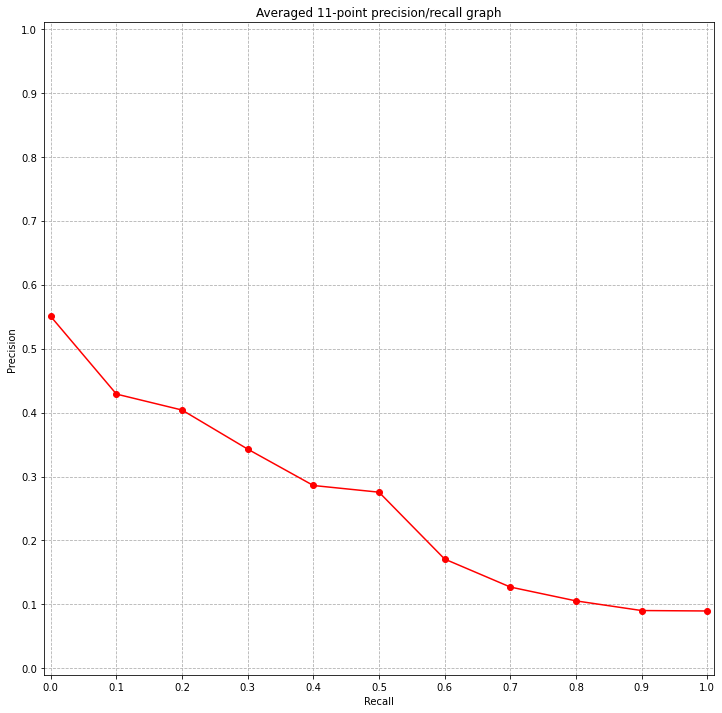

11 points interpolated average: [0.55033297 0.42893864 0.40397471 0.34289368 0.28600517 0.27554149
 0.1709701  0.12723299 0.10558913 0.09047707 0.08980151]


In [18]:
def evaluate_search(search_results, relevance, plot=True):
    """
    Method that prints metrics in stdout for a given search results.
    Metrics supported: mean average precision, normalized discounted cumulative
    gain, pFound, 11 points interpolated average.
    
    :search_results: set of ranked retrieval results.
    :relevance: set of relevant documents.
    :return: dictionary with metrics scores.
    """
    map_eval = mean_avg_precision(search_results, relevance)
    print(f"Mean Average Precision: {map_eval}")

    ndcg_eval = NDCG(search_results, relevance)
    print(f"Normalized Discounted Cumulative Gain: {ndcg_eval}")

    pFound_eval = pFound(search_results, relevance)
    print(f"pFound: {pFound_eval}")

    eleven_test = eleven_points_interpolated_avg(search_results, relevance, plot=plot)
    print(f"11 points interpolated average: {eleven_test}")
    return {'map': map_eval, 'ndcg': ndcg_eval, 'pFound': pFound_eval, '11-test': eleven_test}
    
evaluation = evaluate_search(search_results, relevance, plot=True)

## 2.3. [M] Better search

The first thing we will start with - implementing another search engine. Use any approach which seams meaningful for you. You can involve text embedding, word preprocessing, threshold tuning, or whatever comes to your mind to make results better.

In [ ]:
! pip install datasets transformers[sentencepiece]

In [ ]:
! pip install faiss-cpu

In [ ]:
! conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [19]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset

In [20]:
def load_models():
    """
    The method that inferences the HuggingFace tokenizer and 
    model from 'all-MiniLM-L6-v2'.

    :return: tokenizer and model objects 
    """
    weights = "sentence-transformers/all-MiniLM-L6-v2"
    tokenizer = AutoTokenizer.from_pretrained(weights)
    model = AutoModel.from_pretrained(weights)
    return tokenizer, model


def load_dataset(docs):
    """
    Method that creates HuggingFace Dataset instance from the 
    Cranfield documents data.

    :param docs: Cranfield documents data.
    :return: Hugging Face dataset.    
    """
    features = ['id', 'author', 'bibliography', 'body', 'title']
    doc_dict = {feature: [] for feature in features}
    for doc in docs:
        for feature in features:
            doc_dict[feature].append(doc[feature])
    dataset = Dataset.from_dict(doc_dict)
    return dataset


def embed(text, tokenizer, model):
    """
    The method that embed the semantic of the text. 
    Uses embedding on the text. Applies transformer to the embedding.
    Extracts attention layer from the transformer. Uses mean pooling 
    technique to obtain single embedding for the text (instead of multiple
    for each word).
    
    :param text: sequence of words to be embedded.
    :param tokenizer: Hugging Face tokenizer.
    :param model: Hugging Face transformer.
    :return: text embedding.
    """
    tokenized_dict = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    word_embeddings = []
    with torch.no_grad():
        word_embeddings = model(**tokenized_dict).last_hidden_state
        word_embeddings_dim = word_embeddings.size()
        removed_padding = tokenized_dict['attention_mask'].unsqueeze(-1).expand(word_embeddings_dim).float()
    energy = torch.sum(word_embeddings * removed_padding, dim=1)
    mean_pooling = energy / torch.clamp(torch.sum(removed_padding, dim=1), min=1e-8)
    return mean_pooling


def prepare_search_space(dataset, tokenizer, model):
    """
    Method that embedds each document in the dataset and applies
    faiss index to speed up the searching process. Uses

    :param dataset: Hugging Face dataset.
    :param tokenizer: Hugging Face tokenizer.
    :param model: Hugging Face transformer.
    :return: embedded dataset.
    """
    dataset_embedding = dataset.map(lambda x: {"embedding": embed(f"{x['title']} {x['body']}", tokenizer, model).cpu().numpy()[0]})
    dataset_embedding.add_faiss_index(column="embedding") 
    return dataset_embedding 


def better_search(query, documents, tokenizer=None, model=None, num_items=50):
    """
    Method that performs searching for relevant documents for a given query.
    Usess Hugging Face tokenizer to create embeddings. To search in the embedding
    space there is used faiss index.

    :param query: request for information.
    :param documents: list of documents.
    :param tokenizer: Hugging Face tokenizer.
    :param model: Hugging Face transformer.
    :param num_items: number of search results to be returned.
    :return: set of retrieval results.
    """
    if not isinstance(query, str) or not documents:
        return []
    if not tokenizer or not model:
        tokenizer, model = load_models()
    if isinstance(documents, list):
        for document in documents:
            if not isinstance(document, dict):
                return []
            if set(document.keys()) != ['id', 'author', 'bibliography', 'body', 'title']:
                return []
        dataset = load_dataset(documents)
        documents = prepare_search_space(dataset, tokenizer, model)
    query_embedding = embed([query], tokenizer, model)
    query_embedding = query_embedding.cpu().detach().numpy()
    _, samples = documents.get_nearest_examples("embedding", query_embedding, k=num_items)
    return samples['id']


Ok. Here is the the situation. `search()` engine was used in your company for the last 2 years, and you propose your manager to switch to `better_search()`. What should you do?

We will show two thing:
1. Your search engine survives complicated tests.
2. Results of your search engine are statistically significantly better, than of the original search.

## 2.2. [M][10] How stable is your search to some weird test?

1 point per test.

The new search algorithm relies on the text embedding. This technique is computationally expensive (results in ~1m 12s delay), so for the further test I will pass the embedded version of document list. For the input of type list, custom method can generate the embedding on-fly, but this will be quite time consuming. 

In [21]:
tokenizer, model = load_models()
_documents = prepare_search_space(load_dataset(documents), tokenizer, model)

1400ex [01:17, 18.04ex/s]
100%|██████████| 2/2 [00:00<00:00, 222.69it/s]


In [22]:
# should just work
assert better_search("papers on shock-sound wave interaction .", _documents, tokenizer=tokenizer, model=model) is not None

# accepts erroneous input
assert better_search([], _documents, tokenizer=tokenizer, model=model) is not None
assert better_search(None, _documents, tokenizer=tokenizer, model=model) is not None
assert better_search(-123, _documents, tokenizer=tokenizer, model=model) is not None

# can survive strange strings
assert better_search("", _documents, tokenizer=tokenizer, model=model) is not None
assert better_search("สำรองเที่ยวบินเพื่อเริ่มเดินทางกับเรา", _documents, tokenizer=tokenizer, model=model) is not None
assert better_search("~~\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n~" * 10, _documents, tokenizer=tokenizer, model=model) is not None
assert better_search("1234567890" * 10000, _documents, tokenizer=tokenizer, model=model) is not None
assert better_search("㋡" * 10000000, _documents, tokenizer=tokenizer, model=model) is not None

# dataset corruption
assert better_search("supersonic cascade", [], tokenizer=tokenizer, model=model) is not None
assert better_search("supersonic cascade", [_documents[-1]], tokenizer=tokenizer, model=model) is not None

You can test it straight on the list of documents, but be prepared that this will take a while.

In [ ]:
# should just work
assert better_search("papers on shock-sound wave interaction .", documents) is not None

# accepts erroneous input
assert better_search([], documents) is not None
assert better_search(None, documents) is not None
assert better_search(-123, documents) is not None

# can survive strange strings
assert better_search("", documents) is not None
assert better_search("สำรองเที่ยวบินเพื่อเริ่มเดินทางกับเรา", documents) is not None
assert better_search("~~\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n~" * 10, documents) is not None
assert better_search("1234567890" * 10000, documents) is not None
assert better_search("㋡" * 10000000, documents) is not None

# dataset corruption
assert better_search("supersonic cascade", []) is not None
assert better_search("supersonic cascade", [documents[-1]]) is not None

## 2.3. Can we trust your search engine?

**Major assumption:**

```
metric results, measured across the bucket, form a sample of random variable.
```

We will use this assumption to show 2 things:
1. Distributions are different.
2. `better_search()` shows systematicall higher nDCG than `search()`.

### 2.3.1. [M][15] First, we want some visual justification.
If you defend your proposal in front of the committee, it is always good to have visual materials, rather then just numbers. 
Distributions statistics can be visually presented in a form of [box plot](https://en.wikipedia.org/wiki/Box_plot).

1. Collect any (e.g. nDCG) metric values (per single query) for both search engines in two arrays.
2. Build box plot with any tool. [E.g. read this post](https://t.me/iu_aml/54).

In [ ]:
%pip install seaborn

In [ ]:
%pip install pandas

In [ ]:
%pip install tqdm

In [23]:
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import time

In [24]:
def run_experiments(documents, _documents, queries, relevance):
    """
    Method that evaluates baseline and novel search engines using Mean Average Precision, 
    Normalized Discounted Cumulative Gain, pFound metrics.

    :param documents: set of documents to be retrieved.
    :param _documents: Hugging Face dataset with documents to be retrieved.
    :param queries: set of requests for information.
    :param relevance: set of document assessments for each query.
    :return: dictionary with metrics for each algorithm.
    """
    metrics = {
        "Baseline": {
            "Time": [],
            "NDCG": [],
            "MAP": [],
            "pFound": []
        },
        "Novel": {
            "Time": [],
            "NDCG": [],
            "MAP": [],
            "pFound": []
        } 
    }

    for idx, query in enumerate(tqdm(queries[:10])):
        baseline_start = time.time()
        baseline_result = search(query['query'], documents)
        metrics["Baseline"]["Time"].append(time.time() - baseline_start)

        baseline_ndcg = NDCG([baseline_result], {1: relevance[idx + 1]})
        baseline_map = mean_avg_precision([baseline_result], {1: relevance[idx + 1]})
        baseline_pFound = pFound([baseline_result], {1: relevance[idx + 1]})

        metrics["Baseline"]["NDCG"].append(baseline_ndcg)
        metrics["Baseline"]["MAP"].append(baseline_map)
        metrics["Baseline"]["pFound"].append(baseline_pFound)

        competitor_start = time.time()
        competitor_result = better_search(query['query'], _documents)
        metrics["Novel"]["Time"].append(time.time() - competitor_start)

        competitor_ndcg = NDCG([competitor_result], {1: relevance[idx + 1]})
        competitor_map = mean_avg_precision([competitor_result], {1: relevance[idx + 1]})
        competitor_pFound = pFound([competitor_result], {1: relevance[idx + 1]})

        metrics["Novel"]["NDCG"].append(competitor_ndcg)
        metrics["Novel"]["MAP"].append(competitor_map)
        metrics["Novel"]["pFound"].append(competitor_pFound)
    
    return metrics

metrics = run_experiments(documents, _documents, queries, relevance)

100%|██████████| 10/10 [01:37<00:00,  9.71s/it]


In [25]:
def reconstruct_dataframe(metrics, include_time=False):
    """
    Method that creates a pandas DataFrame from output of run_experiments
    function. It is handy to use for plotting via seaborn.

    :param metrics: dictionary with metrics for each algorithm.
    :param include_time: flag whether 'Time' parameter should be included in DataFrame.
    :return: DataFrame with metrics.
    """
    algorithm_col, metric_col, value_col = [], [], []
    for algorithm, results in metrics.items():
        for metric, values in results.items():
            if metric == "Time" and not include_time:
                continue
            for value in values:
                algorithm_col.append(algorithm)
                metric_col.append(metric)
                value_col.append(value)
    df_dict = {"Metric Type": metric_col, "Algorithm": algorithm_col, "Value": value_col}
    df = pd.DataFrame(data=df_dict)
    return df

df = reconstruct_dataframe(metrics)

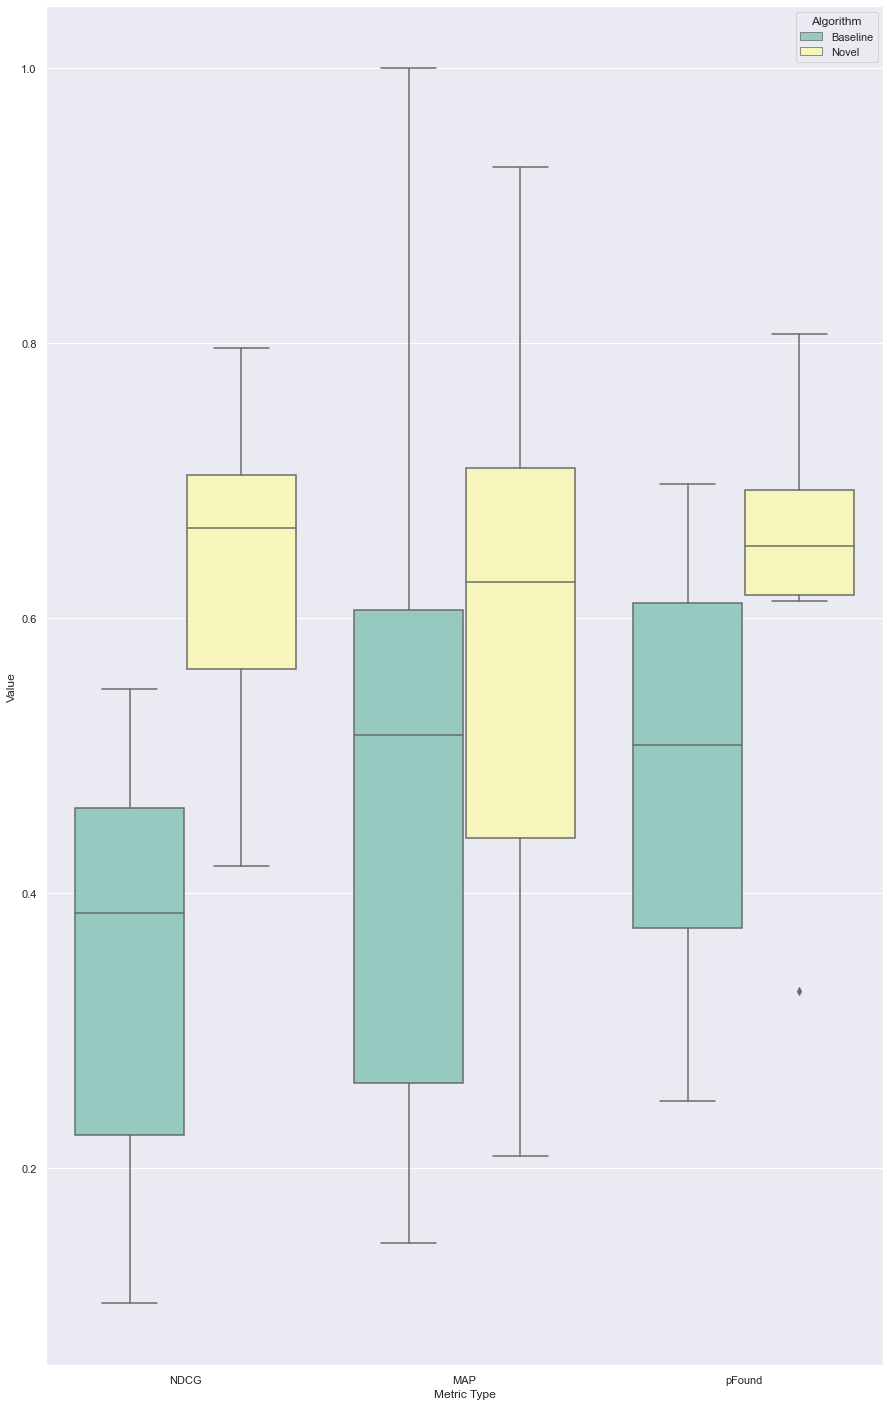

In [26]:
def visualize_boxplot(df, figsize=(15, 25)):
    """
    Method that visualizes metrics for search engines as a boxplots.
    
    :param df: DataFrame to be plotted.
    :param figsize: size of figure to be plotted.
    """
    sns.set(rc={'figure.figsize': figsize})
    sns.boxplot(x="Metric Type", y="Value", hue="Algorithm", data=df, palette="Set3")
    plt.show()

visualize_boxplot(df)

### 2.3.2. [M][15] Distibutions are different

In this task we will use [Kolmogorov-Smirnov test](https://towardsdatascience.com/how-to-compare-two-distributions-in-practice-8c676904a285) to ensure the distributions are different (or not, it will depend on your implementations).
1. Run two-tailed test and show that the hypothesis **"Distributions are the same" can be rejected**.
2. Run one-tailed test which shows that **"BetterSearch(X) distribution is shifted to the right compared to Search(X)" cannot be rejected**.

To get full points:
1. Write your code to run the test.
2. *AND* write short report for a "top-manager with no technical education", why these numbers support your proposal.
3. Don't forget about statistical significance.

In [ ]:
# YOUR CODE HERE

TODO: your report here